# Analisis hidrologi dengan hidrokit

Buku (_notebook_) ini mendemonstrasikan analisis hidrologi menggunakan python dan paket hidrokit sebagai alternatif dari penggunaan _spreadsheet_ (Excel). Dataset yang digunakan merupakan dataset sembarang dengan nama sembarang. Kunjungi notebook manual untuk referensi lebih lanjut mengenai fungsi yang digunakan. Buku ini hanya untuk memeragakan penggunaan modul pada paket hidrokit sehingga kekeliruan teori/konsep mohon diabaikan.

Buku ini memeragakan:

- Mengambil dataset harian dari berkas excel yang menggunakan _template_ hidrokit. (hk88)
- Mengolah data dari berkas excel BMKG. (hk73)
- Menghitung curah hujan rerata dengan metode poligon thiessen (berdasarkan luas area yang telah diketahui). (hk99)
- Merekap data harian menjadi bulanan, 2 periode, dan 4 hari. (hk98)
- Perhitungan evapotranspirasi dengan 3 rumus yaitu Blaney-Criddle, Radiasi, dan Penman. (hk106)
- Pemodelan FJ Mock dan NRECA. (hk96, hk89)
- Menghitung debit andal (kurva durasi). (hk87)
- Mencari parameter model terbaik berdasarkan metrik NSE. (hk90)

## Catatan

- Buku ini harus menggunakan versi hidrokit >= 0.3.5. Kunjungi [halaman rilis update 0.3.5](https://github.com/hidrokit/hidrokit/releases/tag/0.3.5) untuk lebih jelasnya.
- Sitasi hidrokit dapat ditulis: Megariansyah, Taruma. hidrokit: analisis hidrologi dengan python. Zenodo. http://doi.org/10.5281/zenodo.3276220
- Jika memiliki pertanyaan, ide, saran, atau kritik dapat memulai diskusinya dengan membuat isu di [forum diskusi hidrokit](https://github.com/hidrokit/hidrokit/discussions), atau menghubungi saya di $hi@taruma.info$. 

# TAHAP 0: PERSIAPAN DAN DATASET

## Pengaturan Buku

In [ ]:
print(':: MEMERIKSA PAKET HIDROKIT')
try:
    import hidrokit
except ModuleNotFoundError:
    print(':: INSTALASI PAKET HIDROKIT')
    !pip install hidrokit -q
    import hidrokit

:: MEMERIKSA PAKET HIDROKIT
:: INSTALASI PAKET HIDROKIT


menggunakan paket `HydroErr` yang telah dikembangkan oleh BYU-Hydroinformatics ([situs](https://github.com/BYU-Hydroinformatics/HydroErr)) untuk metrik evaluasi model hidrologi.

In [ ]:
print(':: MEMERIKSA PAKET HYDROERR')
try:
    import HydroErr
except ModuleNotFoundError:
    print(':: INSTALASI PAKET HYDROERR')
    !pip install HydroErr -q
    import HydroErr

:: MEMERIKSA PAKET HYDROERR
:: INSTALASI PAKET HYDROERR


In [ ]:
def _check_system(PACKAGE_LIST='numpy pandas matplotlib'):
    from pkg_resources import get_distribution
    from sys import version_info

    print(':: INFORMASI VERSI SISTEM')
    print(':: {:>12s} version: {:<10s}'.format(
            'python', 
            '{}.{}.{}'.format(*version_info[:3]))
        )
    for package in PACKAGE_LIST.split():
        print(':: {:>12s} version: {:<10s}'.format(
            package, 
            get_distribution(package).version)
        )

_check_system('numpy pandas matplotlib hydroerr hidrokit')

:: INFORMASI VERSI SISTEM
::       python version: 3.6.9     
::        numpy version: 1.17.5    
::       pandas version: 0.25.3    
::   matplotlib version: 3.1.3     
::     hydroerr version: 1.24      
::     hidrokit version: 0.3.5     


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.5f}'.format

print(':: IMPORT LIBRARY (NUMPY, PANDAS, MATPLOTLIB)')

:: IMPORT LIBRARY (NUMPY, PANDAS, MATPLOTLIB)


## Dataset

In [ ]:
URL_DEBIT = 'https://taruma.github.io/assets/hidrokit_dataset/hidrokit_poc_demo_debit.xlsx'
URL_HUJAN = 'https://taruma.github.io/assets/hidrokit_dataset/hidrokit_poc_demo_hujan.xlsx'
URL_KLIMATOLOGI = 'https://taruma.github.io/assets/hidrokit_dataset/hidrokit_poc_demo_klimatologi.xlsx'

print(':: ALAMAT DATASET')
print(f':: URL_HUJAN = {URL_HUJAN}')
print(f':: URL_DEBIT = {URL_DEBIT}')
print(f':: URL_KLIMATOLOGI = {URL_KLIMATOLOGI}')

:: ALAMAT DATASET
:: URL_HUJAN = https://taruma.github.io/assets/hidrokit_dataset/hidrokit_poc_demo_hujan.xlsx
:: URL_DEBIT = https://taruma.github.io/assets/hidrokit_dataset/hidrokit_poc_demo_debit.xlsx
:: URL_KLIMATOLOGI = https://taruma.github.io/assets/hidrokit_dataset/hidrokit_poc_demo_klimatologi.xlsx


Membaca informasi pada dataset hujan dan debit menggunakan `hidrokit.contrib.taruma.hk79` ([manual](https://gist.github.com/taruma/05dab67fac8313a94134ac02d0398897)). Modul ini hanya digunakan untuk membaca berkas excel yang telah mengikuti format penulisan oleh hidrokit.

In [ ]:
from hidrokit.contrib.taruma import hk79

print(':: MEMBACA INFO DATASET HUJAN DAN DEBIT')
info_hujan = hk79._get_info(URL_HUJAN)
info_debit = hk79._get_info(URL_DEBIT)

:: MEMBACA INFO DATASET HUJAN DAN DEBIT


In [ ]:
def _read_info(INFO):
    for key, value in INFO.items():
        print(':: {}: {}'.format(key, value)) if key != 'key' else None
    print()

print(':: INFO DATASET HUJAN')
_read_info(info_hujan)
print(':: INFO DATASET DEBIT')
_read_info(info_debit)

:: INFO DATASET HUJAN
:: n_stations: 8
:: stations: CIRI, YENNEFER, TRISS, JASKIER, EMHYR, CRACH, ZOLTAN, ROACH
:: source: SKELLIGE

:: INFO DATASET DEBIT
:: n_stations: 1
:: stations: GERALT
:: source: Kaer Mohen



In [ ]:
def _parse_stations(stations):
    return stations.replace(' ', '').split(',')

print(':: MEMPEROLEH LIST STASIUN')
stations_hujan = _parse_stations(info_hujan['stations'])
stations_debit = _parse_stations(info_debit['stations'])
print(f':: stations_hujan = {stations_hujan}')
print(f':: stations_debit = {stations_debit}')

:: MEMPEROLEH LIST STASIUN
:: stations_hujan = ['CIRI', 'YENNEFER', 'TRISS', 'JASKIER', 'EMHYR', 'CRACH', 'ZOLTAN', 'ROACH']
:: stations_debit = ['GERALT']


# TAHAP 1: AKUISISI DATASET

Pembacaan dataset hujan dan debit menggunakan `hidrokit.contrib.taruma.hk88` ([manual](https://gist.github.com/taruma/6d48b3ec9d601019c15fb5833ae03730)), dan dataset klimatologi menggunakan `hidrokit.contrib.taruma.hk73` ([manual](https://gist.github.com/taruma/b00880905f297013f046dad95dc2e284)).

## Data Hujan

In [ ]:
from hidrokit.contrib.taruma import hk88

print(':: MEMBACA DATA HUJAN DARI [URL_HUJAN]')
dataset_hujan = hk88.read_workbook(URL_HUJAN, stations_hujan)
print(':: MENAMPILKAN LIMA BARIS PERTAMA [dataset_hujan]')
dataset_hujan.head()

:: MEMBACA DATA HUJAN DARI [URL_HUJAN]
:: MENAMPILKAN LIMA BARIS PERTAMA [dataset_hujan]


CIRI YENNEFER TRISS JASKIER EMHYR CRACH ZOLTAN ROACH
1998-01-01    -        -     -       -     -     -      -   NaN
1998-01-02    -        -     -       7     -     -      -   NaN
1998-01-03   64        5     -       -     5     -      -     -
1998-01-04    -        -     -       -     -     -      -     -
1998-01-05    -        -     -       -     -     -      -     -

In [ ]:
print(':: INFORMASI [dataset_hujan]')
dataset_hujan.info()

:: INFORMASI [dataset_hujan]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 1998-01-01 to 2008-12-31
Freq: D
Data columns (total 8 columns):
CIRI        4016 non-null object
YENNEFER    4017 non-null object
TRISS       4018 non-null object
JASKIER     4018 non-null object
EMHYR       4018 non-null object
CRACH       4018 non-null object
ZOLTAN      4018 non-null object
ROACH       4016 non-null object
dtypes: object(8)
memory usage: 282.5+ KB


## Data Debit

In [ ]:
print(':: MEMBACA DATA DEBIT DARI [URL_DEBIT]')
dataset_debit = hk88.read_workbook(URL_DEBIT, stations_debit)
print(':: MENAMPILKAN LIMA BARIS PERTAMA [dataset_debit]')
dataset_debit.head()

:: MEMBACA DATA DEBIT DARI [URL_DEBIT]
:: MENAMPILKAN LIMA BARIS PERTAMA [dataset_debit]


GERALT
1998-01-01      0
1998-01-02      0
1998-01-03      0
1998-01-04      0
1998-01-05      0

In [ ]:
print(':: INFORMASI [dataset_debit]')
dataset_debit.info()

:: INFORMASI [dataset_debit]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 1998-01-01 to 2008-12-31
Freq: D
Data columns (total 1 columns):
GERALT    4017 non-null object
dtypes: object(1)
memory usage: 62.8+ KB


## Data Klimatologi

In [ ]:
from hidrokit.contrib.taruma import hk73

print(':: MEMBACA DATA KLIMATOLOGI DARI [URL_KLIMATOLOGI]')
dataset_klimatologi = hk73._read_bmkg(URL_KLIMATOLOGI)
print(':: MENAMPILKAN LIMA BARIS PERTAMA [dataset_klimatologi]')
dataset_klimatologi.head()

:: MEMBACA DATA KLIMATOLOGI DARI [URL_KLIMATOLOGI]
:: MENAMPILKAN LIMA BARIS PERTAMA [dataset_klimatologi]


Tn       Tx     Tavg  RH_avg  ...  ff_x  ddd_x  ff_avg  ddd_car
Tanggal                                        ...                              
1998-01-01 23.00000 34.60000 27.50000      75  ...     5    225       2       SW
1998-01-02 23.20000 34.20000 28.60000      69  ...     4    270       1       NE
1998-01-03 24.00000 34.60000 27.70000      76  ...     7    270       2       W 
1998-01-04 23.80000 34.40000 28.40000      70  ...     7    225       3       SW
1998-01-05 23.50000 33.40000 27.70000      74  ...     6    270       2       W 

[5 rows x 10 columns]

In [ ]:
print(':: INFORMASI [dataset_klimatologi]')
dataset_klimatologi.info()

:: INFORMASI [dataset_klimatologi]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 1998-01-01 to 2008-12-31
Data columns (total 10 columns):
Tn         4018 non-null float64
Tx         4018 non-null float64
Tavg       4018 non-null float64
RH_avg     4018 non-null int64
RR         4018 non-null float64
ss         4017 non-null float64
ff_x       4018 non-null int64
ddd_x      4018 non-null int64
ff_avg     4018 non-null int64
ddd_car    4018 non-null object
dtypes: float64(5), int64(4), object(1)
memory usage: 345.3+ KB


# TAHAP 2: PRAPEMROSESAN DATA

Dalam tahap ini menggunakan `hidrokit.contrib.taruma.hk43` ([manual](https://gist.github.com/taruma/a9dd4ea61db2526853b99600909e9c50)) yang digunakan untuk memeriksa nilai invalid pada dataset.

In [ ]:
def find_invalid(df):
    results = {}
    for col in df.columns:
        results[col] = hk43._check_invalid(df.loc[:, col].values)
    return results

## Data Hujan

In [ ]:
from hidrokit.contrib.taruma import hk43

print(':: MEMBACA NILAI INVALID PADA [dataset_hujan]')
invalid_hujan = find_invalid(dataset_hujan)

print(':: MENAMPILKAN NILAI INVALID PADA [dataset_hujan] SETIAP STASIUNNYA')
pd.DataFrame(invalid_hujan).T

:: MEMBACA NILAI INVALID PADA [dataset_hujan]
:: MENAMPILKAN NILAI INVALID PADA [dataset_hujan] SETIAP STASIUNNYA


-         NaN
CIRI      [0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15...  [211, 576]
YENNEFER  [0, 1, 3, 4, 5, 6, 8, 9, 11, 14, 16, 17, 19, 2...      [2558]
TRISS     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...         NaN
JASKIER   [0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 15, 17, ...         NaN
EMHYR     [0, 1, 3, 4, 5, 8, 11, 12, 17, 19, 20, 22, 45,...         NaN
CRACH     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16,...         NaN
ZOLTAN    [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 17, 18...         NaN
ROACH     [2, 3, 4, 5, 16, 17, 18, 19, 20, 21, 22, 24, 2...      [0, 1]

In [ ]:
print(':: MENGOREKSI NILAI INVALID')
print(':: MENGUBAH NILAI "-" MENJADI 0.')
dataset_hujan[dataset_hujan == '-'] = 0
print(':: MENYESUAIKAN OBJEK [dataset_hujan] MENJADI NUMERIK')
dataset_hujan = dataset_hujan.infer_objects()
print(':: MENGISI NILAI KOSONG DENGAN METODE INTERPOLASI')
dataset_hujan.interpolate(method='linear', inplace=True)
print(':: MENGISI NILAI KOSONG PADA BARIS PERTAMA DENGAN METODE BACKFILL')
dataset_hujan.bfill(inplace=True)

:: MENGOREKSI NILAI INVALID
:: MENGUBAH NILAI "-" MENJADI 0.
:: MENYESUAIKAN OBJEK [dataset_hujan] MENJADI NUMERIK
:: MENGISI NILAI KOSONG DENGAN METODE INTERPOLASI
:: MENGISI NILAI KOSONG PADA BARIS PERTAMA DENGAN METODE BACKFILL


In [ ]:
print(':: MENAMPILKAN INFORMASI [dataset_hujan]')
dataset_hujan.info()

:: MENAMPILKAN INFORMASI [dataset_hujan]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 1998-01-01 to 2008-12-31
Freq: D
Data columns (total 8 columns):
CIRI        4018 non-null float64
YENNEFER    4018 non-null float64
TRISS       4018 non-null float64
JASKIER     4018 non-null float64
EMHYR       4018 non-null float64
CRACH       4018 non-null float64
ZOLTAN      4018 non-null float64
ROACH       4018 non-null float64
dtypes: float64(8)
memory usage: 282.5 KB


:: GRAFIK [dataset_hujan]


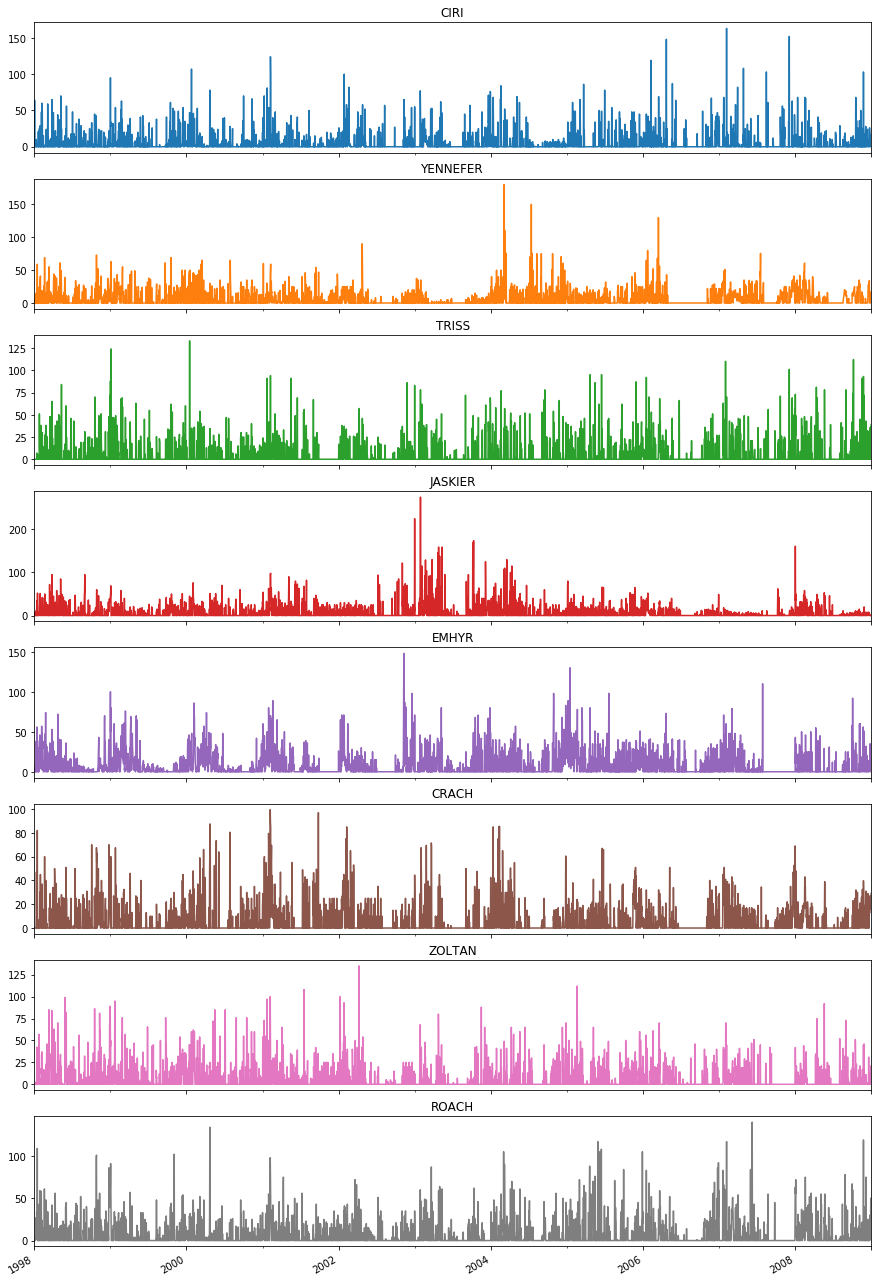

In [ ]:
print(':: GRAFIK [dataset_hujan]')
dataset_hujan.plot(subplots=True, sharex=True, figsize=(15, 25), title=dataset_hujan.columns.to_list(), legend=False);

## Data Debit

In [ ]:
print(':: MEMBACA NILAI INVALID PADA [dataset_debit]')
invalid_debit = find_invalid(dataset_debit)

print(':: MENAMPILKAN NILAI INVALID PADA [dataset_debit]')
pd.DataFrame(invalid_debit).T

:: MEMBACA NILAI INVALID PADA [dataset_debit]
:: MENAMPILKAN NILAI INVALID PADA [dataset_debit]


20.9.46    NaN     tad
GERALT   [309]  [789]  [2974]

In [ ]:
print(':: MENGOREKSI NILAI YANG KELIRU DARI "20.9.46" MENJADI "209.46"')
dataset_debit[dataset_debit == '20.9.46'] = 209.46
print(':: MENGUBAH NILAI "tad" MENJADI 0.')
dataset_debit[dataset_debit == 'tad'] = 0.
print(':: MENYESUAIKAN OBJEK [dataset_debit] MENJADI NUMERIK')
dataset_debit = dataset_debit.infer_objects()
print(':: MENGISI NILAI KOSONG DENGAN METODE INTERPOLASI')
dataset_debit.interpolate(method='linear', inplace=True)

:: MENGOREKSI NILAI YANG KELIRU DARI "20.9.46" MENJADI "209.46"
:: MENGUBAH NILAI "tad" MENJADI 0.
:: MENYESUAIKAN OBJEK [dataset_debit] MENJADI NUMERIK
:: MENGISI NILAI KOSONG DENGAN METODE INTERPOLASI


In [ ]:
print(':: MENAMPILKAN INFORMASI [dataset_debit]')
dataset_debit.info()

:: MENAMPILKAN INFORMASI [dataset_debit]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 1998-01-01 to 2008-12-31
Freq: D
Data columns (total 1 columns):
GERALT    4018 non-null float64
dtypes: float64(1)
memory usage: 62.8 KB


:: GRAFIK DEBIT [dataset_debit]


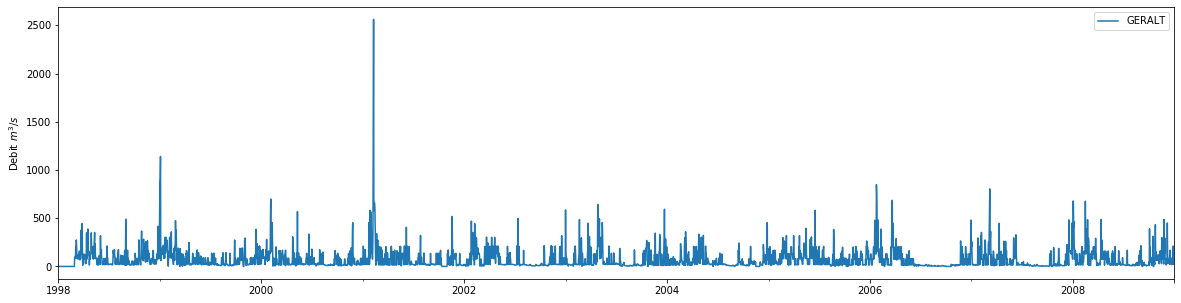

In [ ]:
print(':: GRAFIK DEBIT [dataset_debit]')
ax = dataset_debit.plot(figsize=(20, 5))
ax.set_ylabel('Debit $m^3/s$');

melihat pada awal tahun terdapat nilai 0. secara berurutan setiap harinya, maka dataset dimulai dari Maret 1998.

## Data Klimatologi

Pemrosesan data klimatologi menggunakan `hidrokit.contrib.taruma.hk73` ([manual](https://gist.github.com/taruma/b00880905f297013f046dad95dc2e284))

In [ ]:
print(':: MEMILIH KOLOM KLIMATOLOGI YANG AKAN DIGUNAKAN')
_klim_col = ['Tavg', 'ss', 'RH_avg', 'ff_avg']
print(f':: KOLOM KLIMATOLOGI YANG DIGUNAKAN: {_klim_col}')
dataset_klimatologi = dataset_klimatologi[_klim_col].copy()
print(':: MENGISI NILAI KOSONG DENGAN METODE INTERPOLASI')
dataset_klimatologi.interpolate(method='linear', inplace=True)
print(':: MENGKONVERSI KOLOM "ss" DALAM SATUAN PERSEN')
dataset_klimatologi['ss'] = dataset_klimatologi['ss'] / 8 * 100
print(':: MENGUBAH NAMA KOLOM [dataset_klimatologi]')
dataset_klimatologi.columns = ['TEMP', 'SUN', 'HUMID', 'WIND']
print(':: MENAMPILKAN LIMA BARIS PERTAMA [dataset_klimatologi]')
dataset_klimatologi.head()

:: MEMILIH KOLOM KLIMATOLOGI YANG AKAN DIGUNAKAN
:: KOLOM KLIMATOLOGI YANG DIGUNAKAN: ['Tavg', 'ss', 'RH_avg', 'ff_avg']
:: MENGISI NILAI KOSONG DENGAN METODE INTERPOLASI
:: MENGKONVERSI KOLOM "ss" DALAM SATUAN PERSEN
:: MENGUBAH NAMA KOLOM [dataset_klimatologi]
:: MENAMPILKAN LIMA BARIS PERTAMA [dataset_klimatologi]


TEMP       SUN  HUMID  WIND
Tanggal                                   
1998-01-01 27.50000  72.50000     75     2
1998-01-02 28.60000  95.00000     69     1
1998-01-03 27.70000  70.00000     76     2
1998-01-04 28.40000 100.00000     70     3
1998-01-05 27.70000  43.75000     74     2

In [ ]:
print(':: MEMERIKSA APAKAH TERDAPAT DATA YANG HILANG (8888/9999)')
hk73._get_missing(dataset_klimatologi)

:: MEMERIKSA APAKAH TERDAPAT DATA YANG HILANG (8888/9999)


{'HUMID': array([], dtype=int64),
 'SUN': array([], dtype=int64),
 'TEMP': array([], dtype=int64),
 'WIND': array([], dtype=int64)}

diketahui bahwa `dataset_klimatologi` tidak memiliki data yang hilang (8888/9999).

:: GRAFIK [dataset_klimatologi]


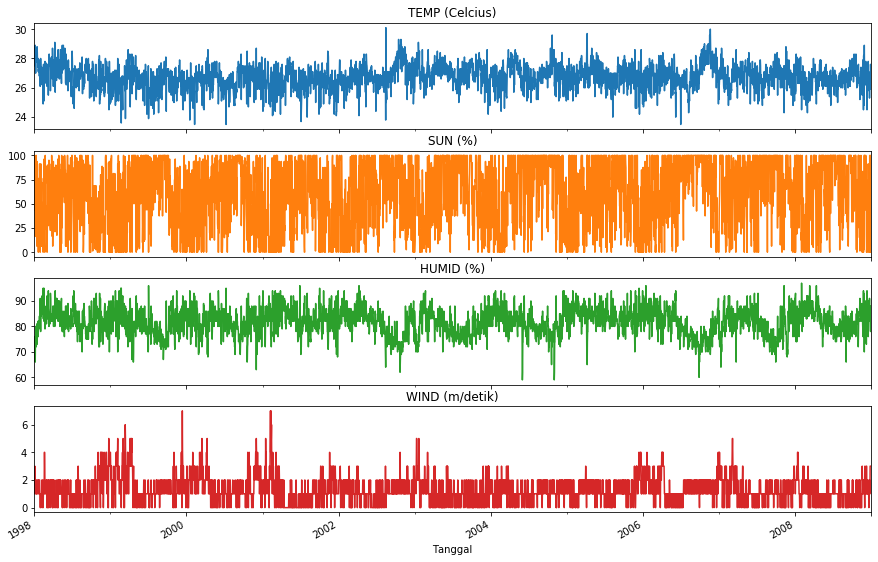

In [ ]:
print(':: GRAFIK [dataset_klimatologi]')
_klim_title = ['TEMP (Celcius)', 'SUN (%)', 'HUMID (%)', 'WIND (m/detik)']
dataset_klimatologi.plot(subplots=True, sharex=True, figsize=(15, 10), 
                         title=_klim_title, legend=False);

# TAHAP 3: INPUT ANALISIS

## Periode dataset

In [ ]:
print(':: PERIODE DIMULAI DARI 1 MARET 1998')
_period = slice('19980301', None)

hujan = dataset_hujan[_period]
print('\n:: MENAMPILKAN INFORMASI [hujan]')
hujan.info()
debit = dataset_debit[_period]
print('\n:: MENAMPILKAN INFORMASI [debit]')
debit.info()
klimatologi = dataset_klimatologi[_period]
print('\n:: MENAMPILKAN INFORMASI [kilimatologi]')
klimatologi.info()

:: PERIODE DIMULAI DARI 1 MARET 1998

:: MENAMPILKAN INFORMASI [hujan]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3959 entries, 1998-03-01 to 2008-12-31
Freq: D
Data columns (total 8 columns):
CIRI        3959 non-null float64
YENNEFER    3959 non-null float64
TRISS       3959 non-null float64
JASKIER     3959 non-null float64
EMHYR       3959 non-null float64
CRACH       3959 non-null float64
ZOLTAN      3959 non-null float64
ROACH       3959 non-null float64
dtypes: float64(8)
memory usage: 278.4 KB

:: MENAMPILKAN INFORMASI [debit]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3959 entries, 1998-03-01 to 2008-12-31
Freq: D
Data columns (total 1 columns):
GERALT    3959 non-null float64
dtypes: float64(1)
memory usage: 61.9 KB

:: MENAMPILKAN INFORMASI [kilimatologi]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3959 entries, 1998-03-01 to 2008-12-31
Data columns (total 4 columns):
TEMP     3959 non-null float64
SUN      3959 non-null float64
HUMID    3959 non

## Hujan rata-rata dengan Metode Thiessen

Menghitung hujan rerata dari 8 stasiun dengan metode poligon thiessen. Perhitungan menggunakan modul `hidrokit.contrib.taruma.hk99` ([manual](https://gist.github.com/taruma/8dd920bee9fa95cf6eba39cc9d694953))

In [ ]:
print(':: BESAR WILAYAH MASING-MASING STASIUN DISIMPAN SEBAGAI [AREA_BASIN]')
AREA_BASIN = {
    'CIRI': 18.638,
    'YENNEFER': 208.920,
    'TRISS': 147.520,
    'JASKIER': 499.413,
    'EMHYR': 205.003,
    'CRACH': 76.695,
    'ZOLTAN': 127.507,
    'ROACH': 166.899
}
print(':: [AREA_BASIN] (DALAM SATUAN LUAS)')
print(AREA_BASIN)

:: BESAR WILAYAH MASING-MASING STASIUN DISIMPAN SEBAGAI [AREA_BASIN]
:: [AREA_BASIN] (DALAM SATUAN LUAS)
{'CIRI': 18.638, 'YENNEFER': 208.92, 'TRISS': 147.52, 'JASKIER': 499.413, 'EMHYR': 205.003, 'CRACH': 76.695, 'ZOLTAN': 127.507, 'ROACH': 166.899}


In [ ]:
from hidrokit.contrib.taruma import hk99

print(':: MENGHITUNG HUJAN RERATA')
hujan_thiessen = hk99.apply_thiessen(hujan, AREA_BASIN)
print(':: MENAMPILKAN LIMA BARIS PERTAMA NILAI [hujan_thiessen]')
hujan_thiessen.head()

:: MENGHITUNG HUJAN RERATA
:: MENAMPILKAN LIMA BARIS PERTAMA NILAI [hujan_thiessen]


thiessen
1998-03-01   1.22327
1998-03-02  13.29924
1998-03-03   6.95701
1998-03-04  12.76077
1998-03-05  11.10122

:: GRAFIK [hujan_thiessen]


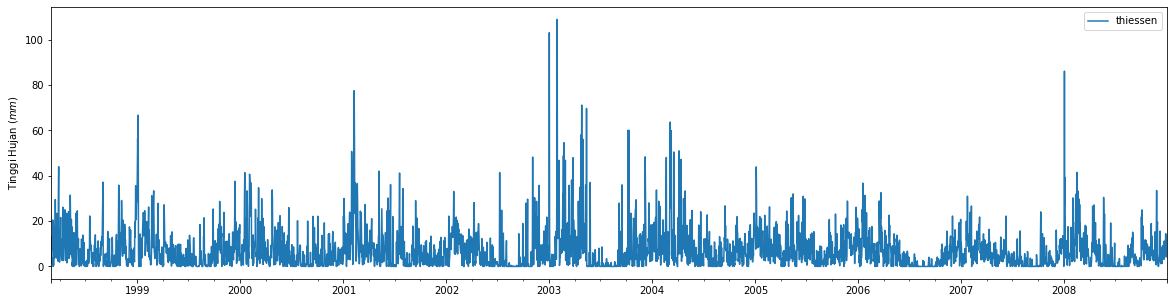

In [ ]:
print(':: GRAFIK [hujan_thiessen]')
hujan_thiessen.plot(figsize=(20, 5)).set_ylabel('Tinggi Hujan ($mm$)');

## Rekap data

Perekapan data menggunakan modul `hidrokit.contrib.taruma.hk98` ([manual](https://gist.github.com/taruma/aca7f90c8fbb0034587809883d0d9e92))

Akan direkap per bulan, per 2 periode, per 4 hari. Untuk data klimatologi, direkap setelah dilakukan proses perhitungan evapotranspirasi. 

In [ ]:
print(':: MEMBUAT FUNGSI UNTUK PEREKAPAN DATA HUJAN')
def n_rain(x):
    return (x > 0).sum()

hujan_func = [np.sum, n_rain, len]
hujan_func_col = ['precip', 'nrain', 'ndays']

:: MEMBUAT FUNGSI UNTUK PEREKAPAN DATA HUJAN


### Bulanan

In [ ]:
from hidrokit.contrib.taruma import hk98

print(':: MEMBUAT REKAP BULANAN [hujan_thiessen] DAN [debit]')
hujan_bulanan = hk98.summary_station(
    hujan_thiessen, column='thiessen', ufunc=hujan_func, ufunc_col=hujan_func_col
    ).droplevel(0, axis=1)

debit_bulanan = hk98.summary_station(
    debit, column='GERALT', ufunc=np.mean, ufunc_col='debit'
    ).droplevel(0, axis=1)

print(':: MENGGABUNGKAN [hujan_bulanan] DAN [debit_bulanan] MENJADI [data_bulanan]')
data_bulanan = pd.concat([hujan_bulanan, debit_bulanan], axis=1)
print(':: MENAMPILKAN INFO [data_bulanan]')
data_bulanan.info()
print('\n:: MENAMPILKAN LIMA BARIS PERTAMA [data_bulanan]')
data_bulanan.head()

:: MEMBUAT REKAP BULANAN [hujan_thiessen] DAN [debit]
:: MENGGABUNGKAN [hujan_bulanan] DAN [debit_bulanan] MENJADI [data_bulanan]
:: MENAMPILKAN INFO [data_bulanan]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130 entries, 1998-03-01 to 2008-12-01
Data columns (total 4 columns):
precip    130 non-null float64
nrain     130 non-null float64
ndays     130 non-null float64
debit     130 non-null float64
dtypes: float64(4)
memory usage: 5.1 KB

:: MENAMPILKAN LIMA BARIS PERTAMA [data_bulanan]


precip    nrain    ndays     debit
1998-03-01 336.18655 30.00000 31.00000 129.03161
1998-04-01 331.19832 30.00000 30.00000 128.41067
1998-05-01 293.26513 29.00000 31.00000 114.43355
1998-06-01 166.98556 28.00000 30.00000  65.54133
1998-07-01 146.26108 28.00000 31.00000  52.90194

:: GRAFIK HUJAN DAN DEBIT [data_bulanan]


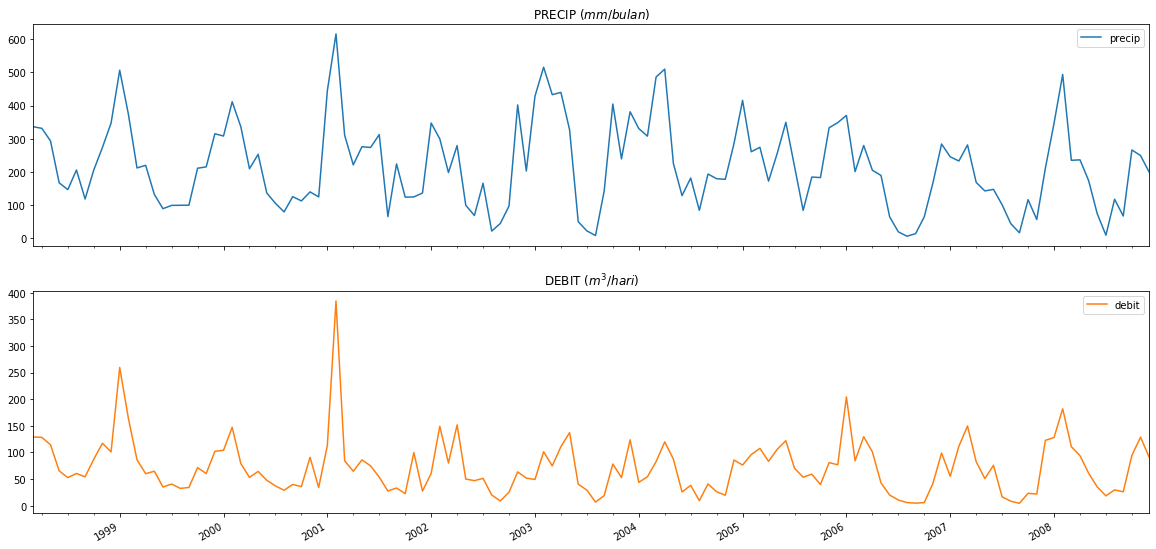

In [ ]:
print(':: GRAFIK HUJAN DAN DEBIT [data_bulanan]')
data_bulanan[['precip', 'debit']].plot(subplots=True, sharex=True, 
                                       title=['PRECIP ($mm/bulan$)',
                                              'DEBIT ($m^3/hari$)'],
                                       figsize=(20, 10));

### 2 Periode (per 16 hari)

Dipilih per 16 hari agar untuk bulan yang memiliki 31 hari, dibagi menjadi 16-15, jika digunakan nilai 15 hari akan menjadi 15-15-1 (3 bagian). 

In [ ]:
_ndays = '16D'

print(':: MEMBUAT REKAP 2 PERIODE [hujan_thiessen] DAN [debit]')
hujan_2p = hk98.summary_station(
    hujan_thiessen, column='thiessen', 
    ufunc=hujan_func, ufunc_col=hujan_func_col,
    n_days=_ndays
    ).droplevel(0, axis=1)

debit_2p = hk98.summary_station(
    debit, column='GERALT', ufunc=np.mean, ufunc_col='debit', n_days=_ndays
    ).droplevel(0, axis=1)

print(':: MENGGABUNGKAN [hujan_2p] DAN [debit_2p] MENJADI [data_2p]')
data_2p = pd.concat([hujan_2p, debit_2p], axis=1)
print(':: MENAMPILKAN INFO [data_2p]')
data_2p.info()
print('\n:: MENAMPILKAN LIMA BARIS PERTAMA [data_2p]')
data_2p.head()

:: MEMBUAT REKAP 2 PERIODE [hujan_thiessen] DAN [debit]
:: MENGGABUNGKAN [hujan_2p] DAN [debit_2p] MENJADI [data_2p]
:: MENAMPILKAN INFO [data_2p]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 1998-03-01 to 2008-12-17
Data columns (total 4 columns):
precip    260 non-null float64
nrain     260 non-null float64
ndays     260 non-null float64
debit     260 non-null float64
dtypes: float64(4)
memory usage: 10.2 KB

:: MENAMPILKAN LIMA BARIS PERTAMA [data_2p]


precip    nrain    ndays     debit
1998-03-01 148.04603 15.00000 16.00000 121.82375
1998-03-17 188.14052 15.00000 15.00000 136.72000
1998-04-01 155.98420 16.00000 16.00000 109.26625
1998-04-17 175.21412 14.00000 14.00000 150.29000
1998-05-01 204.95814 16.00000 16.00000 165.22125

:: GRAFIK HUJAN DAN DEBIT [data_2p]


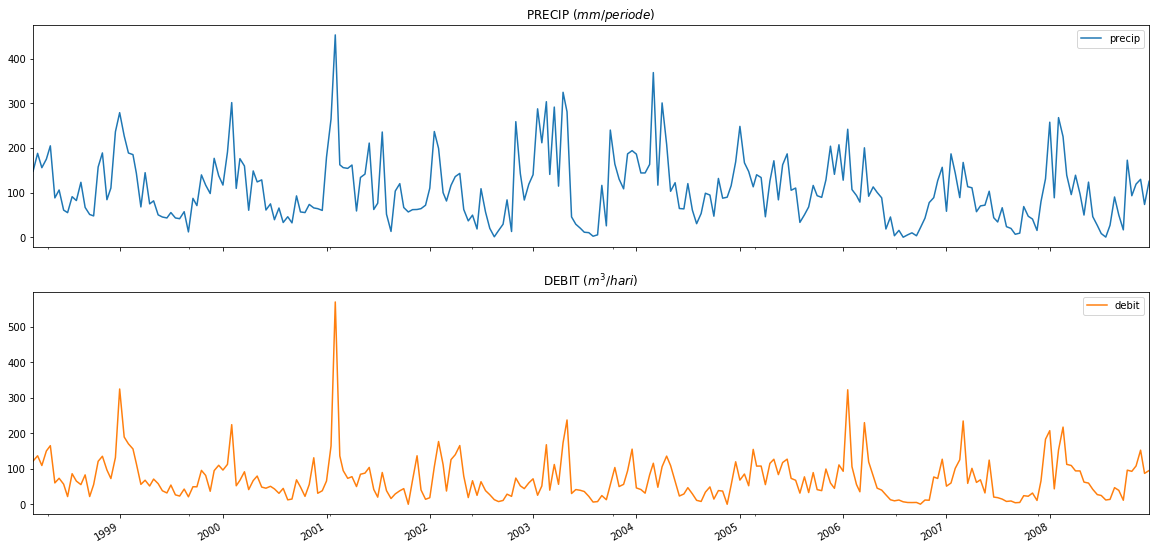

In [ ]:
print(':: GRAFIK HUJAN DAN DEBIT [data_2p]')
data_2p[['precip', 'debit']].plot(subplots=True, sharex=True, 
                                       title=['PRECIP ($mm/periode$)',
                                              'DEBIT ($m^3/hari$)'],
                                       figsize=(20, 10));

### 4 hari

In [ ]:
_ndays = '4D'

print(':: MEMBUAT REKAP 4 HARI [hujan_thiessen] DAN [debit]')
hujan_4d = hk98.summary_station(
    hujan_thiessen, column='thiessen', 
    ufunc=hujan_func, ufunc_col=hujan_func_col,
    n_days=_ndays
    ).droplevel(0, axis=1)

debit_4d = hk98.summary_station(
    debit, column='GERALT', ufunc=np.mean, ufunc_col='debit', n_days=_ndays
    ).droplevel(0, axis=1)

print(':: MENGGABUNGKAN [hujan_4d] DAN [debit_4d] MENJADI [data_4d]')
data_4d = pd.concat([hujan_4d, debit_4d], axis=1)
print(':: MENAMPILKAN INFO [data_4d]')
data_4d.info()
print('\n:: MENAMPILKAN LIMA BARIS PERTAMA [data_4d]')
data_4d.head()

:: MEMBUAT REKAP 4 HARI [hujan_thiessen] DAN [debit]
:: MENGGABUNGKAN [hujan_4d] DAN [debit_4d] MENJADI [data_4d]
:: MENAMPILKAN INFO [data_4d]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1033 entries, 1998-03-01 to 2008-12-29
Data columns (total 4 columns):
precip    1033 non-null float64
nrain     1033 non-null float64
ndays     1033 non-null float64
debit     1033 non-null float64
dtypes: float64(4)
memory usage: 40.4 KB

:: MENAMPILKAN LIMA BARIS PERTAMA [data_4d]


precip   nrain   ndays     debit
1998-03-01 34.24029 4.00000 4.00000  91.80500
1998-03-05 39.90152 3.00000 4.00000 195.93500
1998-03-09 14.69375 4.00000 4.00000  85.15500
1998-03-13 59.21048 4.00000 4.00000 114.40000
1998-03-17 46.60314 4.00000 4.00000  93.14000

:: GRAFIK HUJAN DAN DEBIT [data_4d]


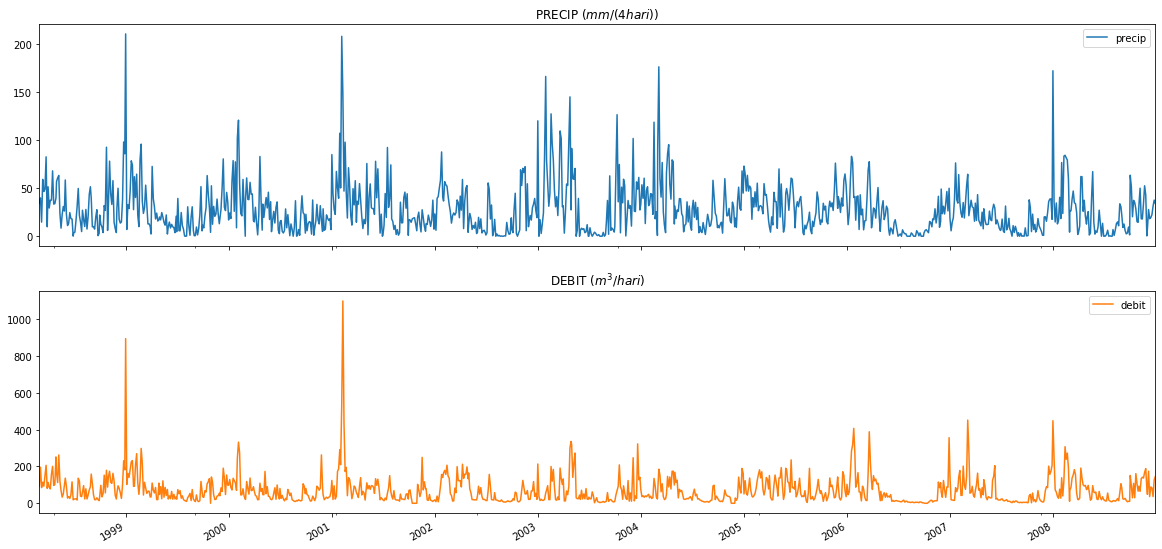

In [ ]:
print(':: GRAFIK HUJAN DAN DEBIT [data_4d]')
data_4d[['precip', 'debit']].plot(subplots=True, sharex=True, 
                                       title=['PRECIP ($mm/(4 hari)$)',
                                              'DEBIT ($m^3/hari$)'],
                                       figsize=(20, 10));

# TAHAP 4: ANALISIS HIDROLOGI

Analisis hidrologi yang akan dilakukan adalah perhitungan evapotranspirasi dan pemodelan NRECA dan F.J. Mock.

## Evapotranspirasi

Perhitungan evapotranspirasi menggunakan data klimatologi yang masih berupa data harian (bukan rekapan). Hasil perhitungan akan direkap per bulan, per 2 periode, per 4 hari.

Perhitungan evapotranspirasi menggunakan modul `hidrokit.contrib.taruma.hk106` ([manual](https://gist.github.com/taruma/7f81cf0fea5250cfe47942b4e16a8a65)).

In [ ]:
print(':: MENENTUKAN GARIS LINTANG LOKASI')
LATITUDE = '6.25 LS'
print(f':: LATITUDE = {LATITUDE}')

:: MENENTUKAN GARIS LINTANG LOKASI
:: LATITUDE = 6.25 LS


### Perhitungan

#### Rumus Blaney-Craddle

:: MENGHITUNG EVAPOTRANSPIRASI MENGGUNAKAN RUMUS BLANEY-CRADDLE
:: GRAFIK [eto_bc]


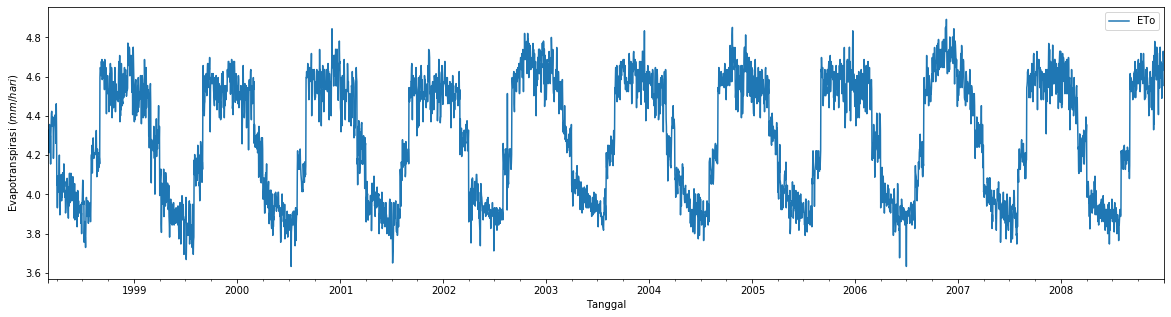

In [ ]:
from hidrokit.contrib.taruma import hk106

print(':: MENGHITUNG EVAPOTRANSPIRASI MENGGUNAKAN RUMUS BLANEY-CRADDLE')
eto_bc = hk106.ETo_BlaneyCriddle(
    klimatologi, temp_col='TEMP', lat=LATITUDE)
print(':: GRAFIK [eto_bc]')
eto_bc.plot(figsize=(20, 5)).set_ylabel('Evapotranspirasi ($mm/hari$)');

#### Rumus Radiasi

:: MENGHITUNG EVAPOTRANSPIRASI MENGGUNAKAN RUMUS RADIASI
:: GRAFIK [eto_rad]


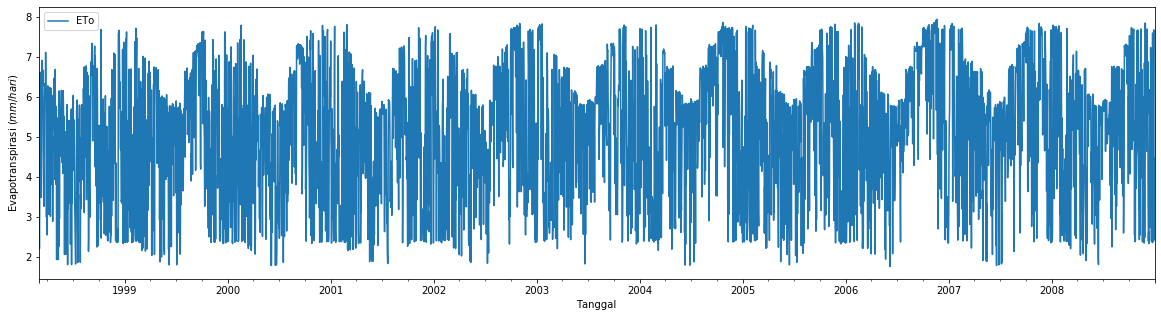

In [ ]:
print(':: MENGHITUNG EVAPOTRANSPIRASI MENGGUNAKAN RUMUS RADIASI')
eto_rad = hk106.ETo_Radiation(
    klimatologi, temp_col='TEMP', sun_col='SUN',
    lat=LATITUDE
)
print(':: GRAFIK [eto_rad]')
eto_rad.plot(figsize=(20, 5)).set_ylabel('Evapotranspirasi ($mm/hari$)');

#### Rumus Penman

:: MENGHITUNG EVAPOTRANSPIRASI MENGGUNAKAN RUMUS PENMAN
:: GRAFIK [eto_penman]


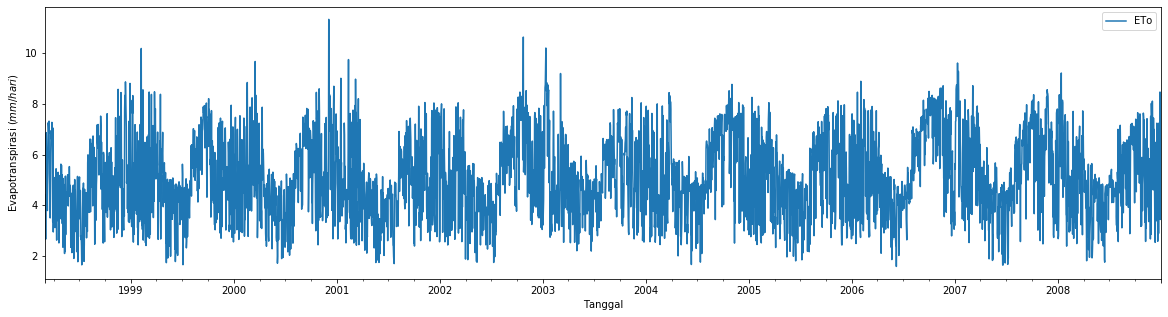

In [ ]:
print(':: MENGHITUNG EVAPOTRANSPIRASI MENGGUNAKAN RUMUS PENMAN')
eto_penman = hk106.ETo_Penman(
    klimatologi,
    'TEMP', 'HUMID', 'WIND', 'SUN',
    lat=LATITUDE
)
print(':: GRAFIK [eto_penman]')
eto_penman.plot(figsize=(20, 5)).set_ylabel('Evapotranspirasi ($mm/hari$)');

### Rekap Evapotranspirasi

Fungsi yang digunakan pada rekap evapotranspirasi untuk setiap durasi rekap yaitu penjumlahan dan rerata. Penjumlahan digunakan untuk model NRECA (mm/periode), sedangkan nilai rerata digunakan untuk model FJMOCK (mm/hari).

#### Bulanan

:: REKAP BULANAN [eto_penman]
:: GRAFIK [eto_bulanan]


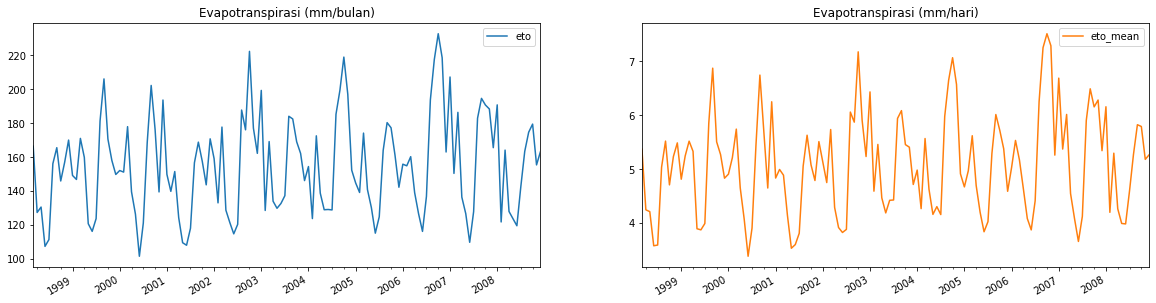

In [ ]:
print(':: REKAP BULANAN [eto_penman]')
eto_bulanan = hk98.summary_station(
    eto_penman, column='ETo', 
    ufunc=[np.sum, np.mean], ufunc_col=['eto', 'eto_mean']
    ).droplevel(0, axis=1)

print(':: GRAFIK [eto_bulanan]')
eto_bulanan.plot(subplots=True, layout=(1,2), figsize=(20, 5), 
                 title=['Evapotranspirasi (mm/bulan)', 
                        'Evapotranspirasi (mm/hari)']
                 );

#### 2 Periode

:: REKAP 2 PERIODE [eto_penman]
:: GRAFIK [eto_2p]


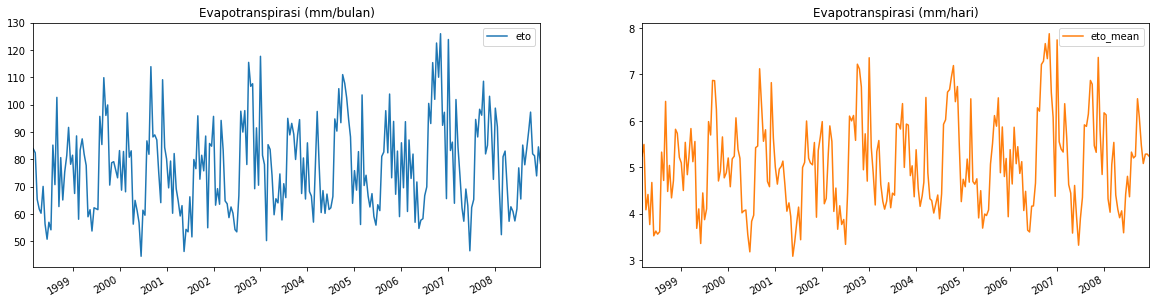

In [ ]:
print(':: REKAP 2 PERIODE [eto_penman]')
eto_2p = hk98.summary_station(
    eto_penman, column='ETo', 
    ufunc=[np.sum, np.mean], ufunc_col=['eto', 'eto_mean'],
    n_days='16D'
    ).droplevel(0, axis=1)
print(':: GRAFIK [eto_2p]')
eto_2p.plot(subplots=True, layout=(1,2), 
            figsize=(20, 5), title=['Evapotranspirasi (mm/bulan)', 
                                    'Evapotranspirasi (mm/hari)']
            );

#### 4 hari

:: REKAP 4 HARI [eto_penman]
:: GRAFIK [eto_4d]


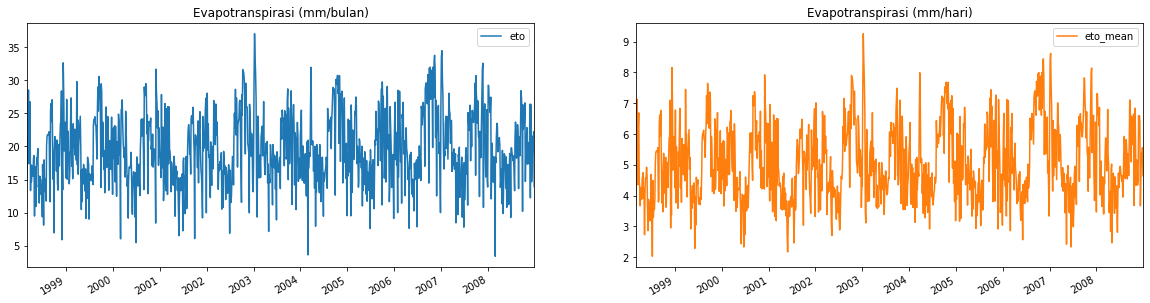

In [ ]:
print(':: REKAP 4 HARI [eto_penman]')
eto_4d = hk98.summary_station(
    eto_penman, column='ETo', 
    ufunc=[np.sum, np.mean], ufunc_col=['eto', 'eto_mean'],
    n_days='4D'
    ).droplevel(0, axis=1)

print(':: GRAFIK [eto_4d]')
eto_4d.plot(subplots=True, layout=(1,2), figsize=(20, 5), 
            title=['Evapotranspirasi (mm/bulan)', 
                   'Evapotranspirasi (mm/hari)']
            );

## Input model NRECA dan FJMOCK

In [ ]:
input_bulanan = pd.concat([data_bulanan, eto_bulanan], axis=1)
print(':: MENAMPILKAN INFO [input_bulanan]')
input_bulanan.info()

:: MENAMPILKAN INFO [input_bulanan]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130 entries, 1998-03-01 to 2008-12-01
Data columns (total 6 columns):
precip      130 non-null float64
nrain       130 non-null float64
ndays       130 non-null float64
debit       130 non-null float64
eto         130 non-null float64
eto_mean    130 non-null float64
dtypes: float64(6)
memory usage: 7.1 KB


In [ ]:
input_2p = pd.concat([data_2p, eto_2p], axis=1)
print(':: MENAMPILKAN INFO [input_2p]')
input_2p.info()

:: MENAMPILKAN INFO [input_2p]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 1998-03-01 to 2008-12-17
Data columns (total 6 columns):
precip      260 non-null float64
nrain       260 non-null float64
ndays       260 non-null float64
debit       260 non-null float64
eto         260 non-null float64
eto_mean    260 non-null float64
dtypes: float64(6)
memory usage: 14.2 KB


In [ ]:
input_4d = pd.concat([data_4d, eto_4d], axis=1)
print(':: MENAMPILKAN INFO [input_4d]')
input_4d.info()

:: MENAMPILKAN INFO [input_4d]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1033 entries, 1998-03-01 to 2008-12-29
Data columns (total 6 columns):
precip      1033 non-null float64
nrain       1033 non-null float64
ndays       1033 non-null float64
debit       1033 non-null float64
eto         1033 non-null float64
eto_mean    1033 non-null float64
dtypes: float64(6)
memory usage: 56.5 KB


## NRECA

Perhitungan menggunakan `hidrokit.contrib.taruma.hk89` ([manual](https://gist.github.com/taruma/1502a7aa67cf074969d806cd3ffdf35c)). Terdapat modifikasi terhadap fungsi `.model_NRECA` agar dapat memroses input yang memiliki periode sembarang (tidak bulanan).

In [ ]:
print(':: PARAMETER PADA FUNGSI .model_NRECA')
nreca_parameter = {
    'MSTOR': 1000,
    'GSTOR': 100,
    'PSUB': 0.4,
    'GWF': 0.2, 
    'CF': 0.6,
    'C': 0.25,
    'AREA': 1450.6e6,
}
print(nreca_parameter)

:: PARAMETER PADA FUNGSI .model_NRECA
{'MSTOR': 1000, 'GSTOR': 100, 'PSUB': 0.4, 'GWF': 0.2, 'CF': 0.6, 'C': 0.25, 'AREA': 1450600000.0}


In [ ]:
print(':: MEMODIFIKASI FUNGSI .model_NRECA')

def model_NRECA_custom(df, precip_col, pet_col, ndays_col,
                MSTOR, GSTOR, PSUB, GWF, CF, C, AREA,
                as_df=True):

    nreca = hk89.model_NRECA(
        df=df, precip_col=precip_col, pet_col=pet_col,
        MSTOR=MSTOR, GSTOR=GSTOR, PSUB=PSUB, GWF=GWF, CF=CF, C=C, AREA=AREA,
                as_df=True, report='flow'
    )

    nreca['DISCHARGE'] = (nreca['FLOW']/1000) * AREA / (df[ndays_col] * 24 * 60 * 60)
    nreca.drop(['FLOW'], axis=1, inplace=True)
    if as_df is True:
        return nreca
    else:
        return nreca['DISCHARGE'].values

def nreca_plot(nreca, input_df):
    ax = nreca.plot(figsize=(20, 5))
    input_df['debit'].plot(ax=ax, style='--')
    ax.legend(['SIMULATION', 'OBSERVED'])
    ax.set_xlabel('WAKTU')
    ax.set_ylabel('DEBIT $(m^3/detik)$')
    ax.set_title('GRAFIK PERBANDINGAN HASIL MODEL DAN OBSERVASI')
    return ax

:: MEMODIFIKASI FUNGSI .model_NRECA


### Bulanan

:: PERHITUNGAN MODEL NRECA (BULANAN)
:: GRAFIK [nreca_bulanan]


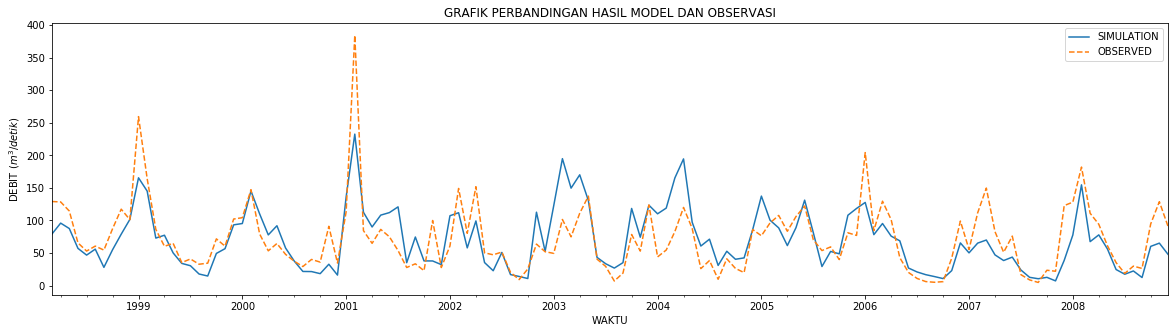

In [ ]:
from hidrokit.contrib.taruma import hk89

print(':: PERHITUNGAN MODEL NRECA (BULANAN)')
nreca_bulanan = hk89.model_NRECA(df=input_bulanan,
                 precip_col='precip', pet_col='eto',
                 **nreca_parameter)
print(':: GRAFIK [nreca_bulanan]')
nreca_plot(nreca_bulanan, input_bulanan);

### 2 Periode

:: PERHITUNGAN MODEL NRECA (2 PERIODE)
:: GRAFIK [nreca_2p]


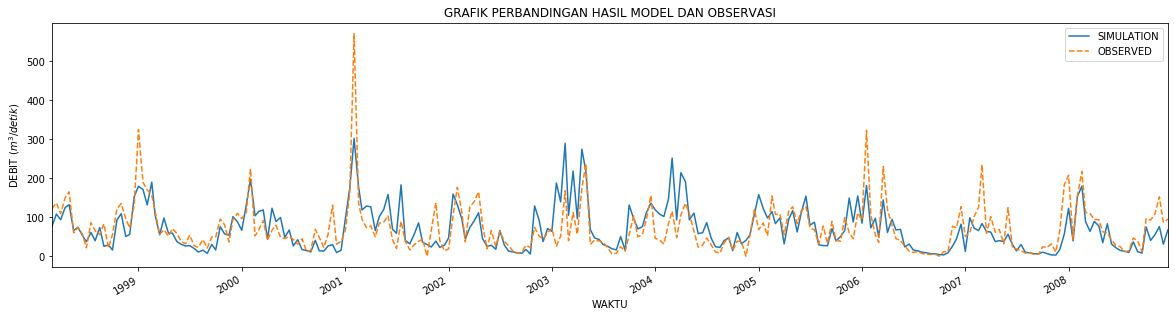

In [ ]:
print(':: PERHITUNGAN MODEL NRECA (2 PERIODE)')
nreca_2p = model_NRECA_custom(df=input_2p,
                 precip_col='precip', pet_col='eto', ndays_col='ndays',
                 **nreca_parameter)
print(':: GRAFIK [nreca_2p]')
nreca_plot(nreca_2p, input_2p);

### 4 Hari

:: PERHITUNGAN MODEL NRECA (4 HARI)
:: GRAFIK [nreca_4d]


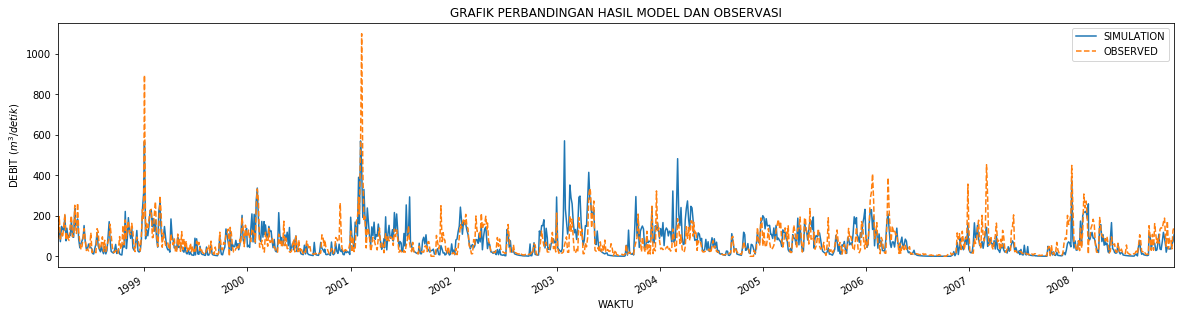

In [ ]:
print(':: PERHITUNGAN MODEL NRECA (4 HARI)')
nreca_4d = model_NRECA_custom(df=input_4d,
                 precip_col='precip', pet_col='eto', ndays_col='ndays',
                 **nreca_parameter)
print(':: GRAFIK [nreca_4d]')
nreca_plot(nreca_4d, input_4d);

## FJ Mock

Perhitungan menggunakan `hidrokit.contrib.taruma.hk96` ([manual](https://gist.github.com/taruma/ae5c0209ef19b088e3cd9dd22508af5c)).

In [ ]:
print(':: PARAMETER FJMOCK')
fjmock_parameter = {
    'EXSURF': 30,
    'IF': 0.5,
    'K': 0.2, 
    'PF': 0.5, 
    'ISMC': 300,
    'GSOM': 300,
    'AREA': 1450.6e6
}
print(fjmock_parameter)

print('\n:: DATASET PARAMETER FJMOCK')
dataset_params = {
    'precip_col': 'precip',
    'ep_col': 'eto_mean',
    'nrain_col': 'nrain',
    'ndays_col': 'ndays'
}
print(dataset_params)

:: PARAMETER FJMOCK
{'EXSURF': 30, 'IF': 0.5, 'K': 0.2, 'PF': 0.5, 'ISMC': 300, 'GSOM': 300, 'AREA': 1450600000.0}

:: DATASET PARAMETER FJMOCK
{'precip_col': 'precip', 'ep_col': 'eto_mean', 'nrain_col': 'nrain', 'ndays_col': 'ndays'}


In [ ]:
def fjmock_plot(fjmock, input_df):
    ax = fjmock.plot(figsize=(20, 5))
    input_df['debit'].plot(ax=ax, style='--')
    ax.legend(['SIMULATION', 'OBSERVED'])
    ax.set_xlabel('WAKTU')
    ax.set_ylabel('DEBIT $(m^3/s)$')
    ax.set_title('GRAFIK PERBANDINGAN HASIL MODEL DAN OBSERVASI')
    return ax

### Bulanan

:: PERHITUNGAN MODEL FJMOCK (BULANAN)
:: GRAFIK [fjmock_bulanan]


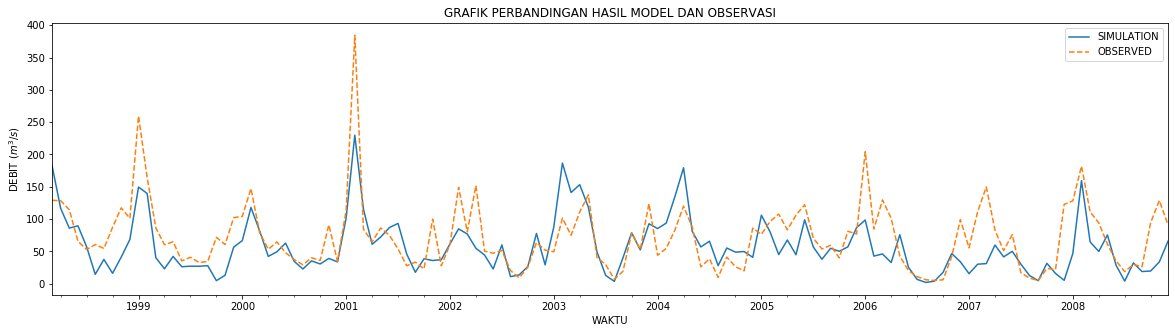

In [ ]:
from hidrokit.contrib.taruma import hk96

print(':: PERHITUNGAN MODEL FJMOCK (BULANAN)')
fjmock_bulanan = hk96.model_FJMOCK(input_bulanan, **dataset_params,
                                   **fjmock_parameter)
print(':: GRAFIK [fjmock_bulanan]')
fjmock_plot(fjmock_bulanan, input_bulanan);

### 2 Periode

:: PERHITUNGAN MODEl FJMOCK (2 PERIODE)
:: GRAFIK [fjmock_2p]


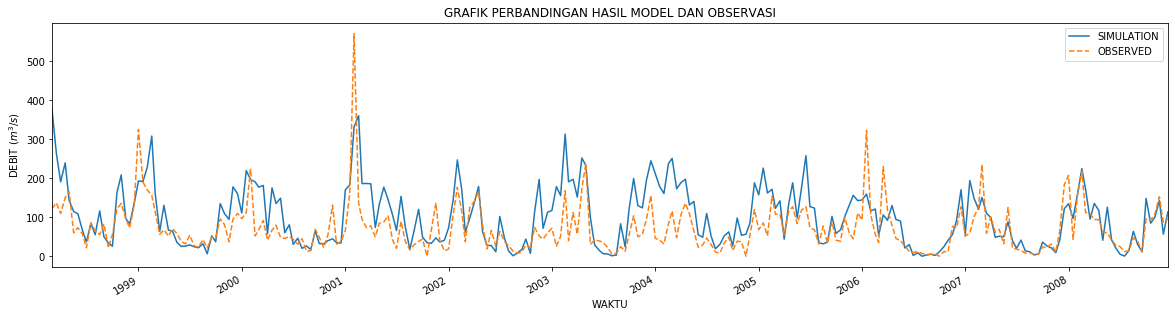

In [ ]:
print(':: PERHITUNGAN MODEl FJMOCK (2 PERIODE)')
fjmock_2p = hk96.model_FJMOCK(input_2p, **dataset_params,
                                   **fjmock_parameter)
print(':: GRAFIK [fjmock_2p]')
fjmock_plot(fjmock_2p, input_2p);

### Per 4 Hari

:: PERHITUNGAN FJMOCK (4 HARI)
:: GRAFIK [fjmock_4d]


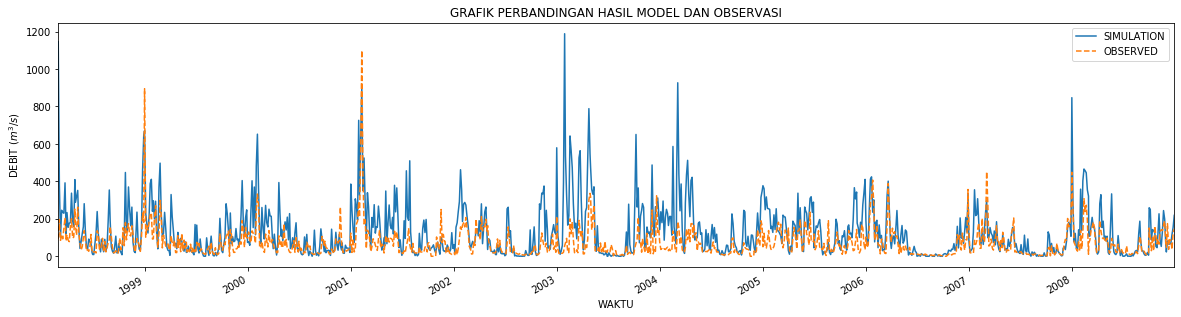

In [ ]:
print(':: PERHITUNGAN FJMOCK (4 HARI)')
fjmock_4d = hk96.model_FJMOCK(input_4d, **dataset_params,
                                   **fjmock_parameter)
print(':: GRAFIK [fjmock_4d]')
fjmock_plot(fjmock_4d, input_4d);

## Debit Andal

Perhitungan debit andal menggunakan modul `hidrokit.contrib.taruma.hk87` ([manual](https://gist.github.com/taruma/0b0ebf3ba12d4acf7cf11df905d2ec9c)). 

:: GRAFIK KURVA DURASI


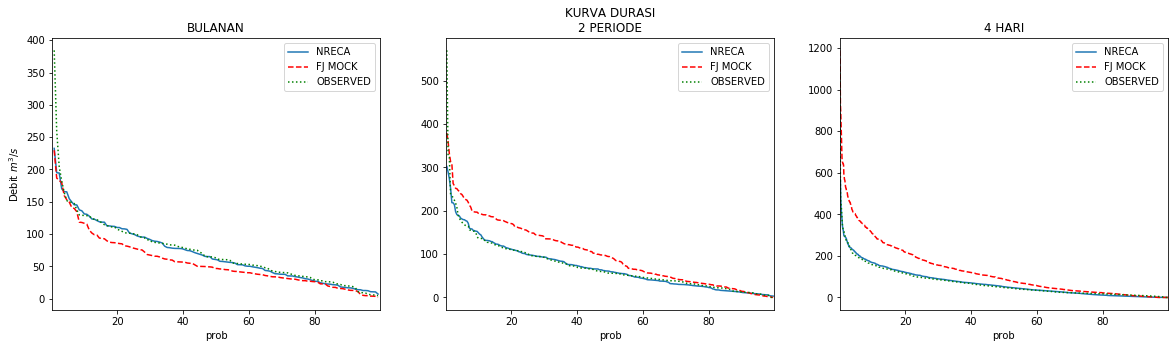

In [ ]:
from hidrokit.contrib.taruma import hk87

def plot_kurva_debit(input_df, nreca_df, fjmock_df):
    input_bulanan, input_2p, input_4d = input_df
    nreca_bulanan, nreca_2p, nreca_4d = nreca_df
    fjmock_bulanan, fjmock_2p, fjmock_4d = fjmock_df

    obs_andal_bulanan = hk87.debit_andal(input_bulanan, 'debit')
    obs_andal_2p = hk87.debit_andal(input_2p, 'debit')
    obs_andal_4d = hk87.debit_andal(input_4d, 'debit')

    fjmock_andal_bulanan = hk87.debit_andal(fjmock_bulanan, 'FLOW')
    fjmock_andal_2p = hk87.debit_andal(fjmock_2p, 'FLOW')
    fjmock_andal_4d = hk87.debit_andal(fjmock_4d, 'FLOW')

    nreca_andal_bulanan = hk87.debit_andal(nreca_bulanan, 'DISCHARGE')
    nreca_andal_2p = hk87.debit_andal(nreca_2p, 'DISCHARGE')
    nreca_andal_4d = hk87.debit_andal(nreca_4d, 'DISCHARGE')

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5),
                        sharex=True, sharey=False)
    nreca_andal_bulanan.plot(x='prob', y='data', ax=ax[0], title='BULANAN')
    nreca_andal_2p.plot(x='prob', y='data', ax=ax[1], title='KURVA DURASI\n2 PERIODE')
    nreca_andal_4d.plot(x='prob', y='data', ax=ax[2], title='4 HARI')
    fjmock_andal_bulanan.plot(x='prob', y='data', ax=ax[0], style='r--')
    fjmock_andal_2p.plot(x='prob', y='data', ax=ax[1], style='r--')
    fjmock_andal_4d.plot(x='prob', y='data', ax=ax[2], style='r--')
    obs_andal_bulanan.plot(x='prob', y='data', ax=ax[0], style='g:')
    obs_andal_2p.plot(x='prob', y='data', ax=ax[1], style='g:')
    obs_andal_4d.plot(x='prob', y='data', ax=ax[2], style='g:')

    ax[0].set_ylabel('Debit $m^3/s$')
    ax[0].legend(['NRECA', 'FJ MOCK', 'OBSERVED'])
    ax[1].legend(['NRECA', 'FJ MOCK', 'OBSERVED'])
    ax[2].legend(['NRECA', 'FJ MOCK', 'OBSERVED'])

print(':: GRAFIK KURVA DURASI')
plot_kurva_debit([input_bulanan, input_2p, input_4d],
                 [nreca_bulanan, nreca_2p, nreca_4d],
                 [fjmock_bulanan, fjmock_2p, fjmock_4d])

In [ ]:
def debit_andal(input_df, nreca_df, fjmock_df):
    input_bulanan, input_2p, input_4d = input_df
    nreca_bulanan, nreca_2p, nreca_4d = nreca_df
    fjmock_bulanan, fjmock_2p, fjmock_4d = fjmock_df

    print(':: DEBIT ANDAL BULANAN')
    print('NRECA:', hk87.debit_andal(nreca_bulanan, 'DISCHARGE', kind='prob'))
    print('FJMOCK:', hk87.debit_andal(fjmock_bulanan, 'FLOW', kind='prob'))
    print('OBSERVED:', hk87.debit_andal(input_bulanan, 'debit', kind='prob'))
    
    print(':: DEBIT ANDAL 2 PERIODE')
    print('NRECA:', hk87.debit_andal(nreca_2p, 'DISCHARGE', kind='prob'))
    print('FJMOCK:', hk87.debit_andal(fjmock_2p, 'FLOW', kind='prob'))
    print('OBSERVED:', hk87.debit_andal(input_2p, 'debit', kind='prob'))

    print(':: DEBIT ANDAL 4 HARI')
    print('NRECA:', hk87.debit_andal(nreca_4d, 'DISCHARGE', kind='prob'))
    print('FJMOCK:', hk87.debit_andal(fjmock_4d, 'FLOW', kind='prob'))
    print('OBSERVED:', hk87.debit_andal(input_4d, 'debit', kind='prob'))

print(':: NILAI DEBIT ANDAL')
debit_andal([input_bulanan, input_2p, input_4d],
            [nreca_bulanan, nreca_2p, nreca_4d],
            [fjmock_bulanan, fjmock_2p, fjmock_4d])

:: NILAI DEBIT ANDAL
:: DEBIT ANDAL BULANAN
NRECA: {80: 27.074238664520262, 90: 16.83447364976881, 95: 12.572521488039039}
FJMOCK: {80: 26.219763305735324, 90: 13.580058048808572, 95: 4.896675772517941}
OBSERVED: {80: 29.44870967741936, 90: 19.844599999999996, 95: 8.880540322580645}
:: DEBIT ANDAL 2 PERIODE
NRECA: {80: 22.98213768010558, 90: 11.771190119073518, 95: 8.291178749294176}
FJMOCK: {80: 30.466330533118406, 90: 14.335412248219853, 95: 5.9557591976358655}
OBSERVED: {80: 25.21499047619047, 90: 12.777500000000005, 95: 7.975470833333335}
:: DEBIT ANDAL 4 HARI
NRECA: {80: 11.420719926160634, 90: 4.496449856941252, 95: 1.6417791808744535}
FJMOCK: {80: 22.170356480795952, 90: 8.007986453904744, 95: 1.8379227489892294}
OBSERVED: {80: 17.352, 90: 10.868, 95: 6.511999999999998}



# TAHAP 5: KALIBRASI

In [ ]:
def _slice_in_index(df, date_start, date_end):
    dfc = df.copy()
    dfc['index'] = np.arange(0, dfc.shape[0])
    sub = dfc[slice(date_start, date_end)]
    return slice(sub['index'].iloc[0], sub['index'].iloc[-1] + 1)

## Metrik

Metrik yang digunakan untuk evaluasi model atau kalibrasi menggunakan paket `HydroErr` berupa `rmse`, `r_squared`, `nse`. Ditambah evaluasi NSE untuk tahun 2006-2008 saja `nse_x_0608`. 

In [ ]:
import HydroErr as he

slice_bulanan0608 = _slice_in_index(input_bulanan, '2006', '2008')
slice_2p0608 = _slice_in_index(input_2p, '2006', '2008')
slice_4d0608 = _slice_in_index(input_4d, '2006', '2008') 

def nse_bulanan_0608(simulasi, observasi):
    sim = simulasi[slice_bulanan0608]
    obs = observasi[slice_bulanan0608]
    return he.nse(sim, obs)

def nse_2p_0608(simulasi, observasi):
    sim = simulasi[slice_2p0608]
    obs = observasi[slice_2p0608]
    return he.nse(sim, obs)

def nse_4d_0608(simulasi, observasi):
    sim = simulasi[slice_4d0608]
    obs = observasi[slice_4d0608]
    return he.nse(sim, obs)


metrics_bulanan = [he.rmse, he.r_squared, he.nse, nse_bulanan_0608]
metrics_2p = [he.rmse, he.r_squared, he.nse, nse_2p_0608]
metrics_4d = [he.rmse, he.r_squared, he.nse, nse_4d_0608]

metrics_parameter = {
    'met_names': ['RMSE', 'R2', 'NSE', 'NSE0608'],
    'met_sort': 'NSE',
    'met_min': False
}

## Kalibrasi NRECA

Kalibrasi model menggunakan modul `hidrokit.contrib.taruma.hk90` ([manual](https://gist.github.com/taruma/906e1577111208291e0725229c7d0a76)).

Pada model NRECA yang akan dicari parameter terbaiknya adalah `PSUB` dan `GWF` dengan batasan $\{[0.2, 0.8) \in \mathbb{R}\}$ dengan nilai _step_ sebesar $0.01$.

In [ ]:
def obs_val(obs_df):
    return obs_df.loc[:, 'debit'].values

In [ ]:
print(':: PARAMETER YANG AKAN DIKALIBRASI')
calib_nreca_params = {
    'MSTOR': [1000],
    'GSTOR': [100],
    'PSUB': np.arange(0.2, 0.8, 0.01),
    'GWF': np.arange(0.2, 0.8, 0.01), 
}
print(f'Kombinasi Parameter [calib_nreca_params]: \n{calib_nreca_params}')

:: PARAMETER YANG AKAN DIKALIBRASI
Kombinasi Parameter [calib_nreca_params]: 
{'MSTOR': [1000], 'GSTOR': [100], 'PSUB': array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ,
       0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41,
       0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52,
       0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63,
       0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74,
       0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ]), 'GWF': array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ,
       0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41,
       0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52,
       0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63,
       0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74,
       0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ])}


In [ ]:
print(':: ARGUMEN FUNGSI NRECA')
func_nreca_params = {
    'CF': 0.6,
    'C': 0.25,
    'AREA': 1450.6e6,

    'ndays_col': 'ndays',
    'precip_col': 'precip',
    'pet_col':'eto',
    'as_df': False,
}
print(f'[func_nreca_params] = {func_nreca_params}')

:: ARGUMEN FUNGSI NRECA
[func_nreca_params] = {'CF': 0.6, 'C': 0.25, 'AREA': 1450600000.0, 'ndays_col': 'ndays', 'precip_col': 'precip', 'pet_col': 'eto', 'as_df': False}


### Bulanan

In [ ]:
from hidrokit.contrib.taruma import hk90

func_nreca_params['df'] = input_bulanan

print(':: KALIBRASI PARAMETER NRECA (BULANAN)')
results_bulanan = hk90.calibration(
    observed=input_bulanan, observed_func=obs_val,
    func=model_NRECA_custom, calibration_parameter=calib_nreca_params,
    func_parameter=func_nreca_params,
    metrics=metrics_bulanan,
    **metrics_parameter
)

:: KALIBRASI PARAMETER NRECA (BULANAN)
N = 3721
PROGRESS 0 [-x--xx--x-] 100
---------> [==========] DONE


In [ ]:
print(':: MENAMPILKAN LIMA BARIS PERTAMA [results_bulanan]')
results_bulanan.head()

:: MENAMPILKAN LIMA BARIS PERTAMA [results_bulanan]


MSTOR  GSTOR    PSUB     GWF     RMSE      R2     NSE  NSE0608
0   1000    100 0.37000 0.20000 36.54280 0.53967 0.51048  0.59667
1   1000    100 0.38000 0.20000 36.54339 0.53756 0.51046  0.59287
2   1000    100 0.36000 0.20000 36.54947 0.54171 0.51030  0.60036
3   1000    100 0.39000 0.20000 36.55123 0.53537 0.51025  0.58896
4   1000    100 0.35000 0.20000 36.56340 0.54368 0.50992  0.60395

### 2 Periode

In [ ]:
func_nreca_params['df'] = input_2p

print(':: KALIBRASI PARAMETER NRECA (2 PERIODE)')
results_2p = hk90.calibration(
    observed=input_2p, observed_func=obs_val,
    func=model_NRECA_custom, calibration_parameter=calib_nreca_params,
    func_parameter=func_nreca_params,
    metrics=metrics_2p,
    **metrics_parameter
)

:: KALIBRASI PARAMETER NRECA (2 PERIODE)
N = 3721
PROGRESS 0 [-x--xx--x-] 100
---------> [==========] DONE


In [ ]:
print(':: MENAMPILKAN LIMA BARIS PERTAMA [results_2p]')
results_bulanan.head()

:: MENAMPILKAN LIMA BARIS PERTAMA [results_2p]


MSTOR  GSTOR    PSUB     GWF     RMSE      R2     NSE  NSE0608
0   1000    100 0.37000 0.20000 36.54280 0.53967 0.51048  0.59667
1   1000    100 0.38000 0.20000 36.54339 0.53756 0.51046  0.59287
2   1000    100 0.36000 0.20000 36.54947 0.54171 0.51030  0.60036
3   1000    100 0.39000 0.20000 36.55123 0.53537 0.51025  0.58896
4   1000    100 0.35000 0.20000 36.56340 0.54368 0.50992  0.60395

### 4 Hari

In [ ]:
func_nreca_params['df'] = input_4d

print(':: KALIBRASI PARAMETER NRECA (4 HARI)')
results_4d = hk90.calibration(
    observed=input_4d, observed_func=obs_val,
    func=model_NRECA_custom, calibration_parameter=calib_nreca_params,
    func_parameter=func_nreca_params,
    metrics=metrics_4d,
    **metrics_parameter
)

:: KALIBRASI PARAMETER NRECA (4 HARI)
N = 3721
PROGRESS 0 [-x--xx--x-] 100
---------> [==========] DONE


In [ ]:
print(':: MENAMPILKAN LIMA BARIS PERTAMA [results_4d]')
results_4d.head()

:: MENAMPILKAN LIMA BARIS PERTAMA [results_4d]


MSTOR  GSTOR    PSUB     GWF     RMSE      R2     NSE  NSE0608
0   1000    100 0.72000 0.39000 61.56053 0.46569 0.40799  0.50410
1   1000    100 0.73000 0.40000 61.56175 0.46668 0.40797  0.50548
2   1000    100 0.71000 0.38000 61.56177 0.46468 0.40797  0.50282
3   1000    100 0.71000 0.39000 61.56200 0.46647 0.40797  0.50680
4   1000    100 0.70000 0.38000 61.56273 0.46549 0.40795  0.50558

### Perbandingan Kalibrasi NRECA setiap periode

In [ ]:
def plot_calib_res(_x):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), 
                        sharex=False, sharey=True)
    ax0, ax1 = ax

    print(':: GRAFIK PARAMETER PSUB DAN GWF TERHADAP NILAI ' + _x)
    results_bulanan.plot.scatter(x=_x, y='PSUB', title='BULANAN\nParameter PSUB', 
                                ax=ax0[0])
    results_4d.plot.scatter(x=_x, y='PSUB', title='2 PERIODE\nParameter PSUB', 
                            ax=ax0[1])
    results_2p.plot.scatter(x=_x, y='PSUB', title='4 HARI\nParameter PSUB', 
                            ax=ax0[2])

    results_bulanan.plot.scatter(x=_x, y='GWF', title='Parameter GWF', ax=ax1[0])
    results_4d.plot.scatter(x=_x, y='GWF', title='Parameter GWF', ax=ax1[1])
    results_2p.plot.scatter(x=_x, y='GWF', title='Parameter GWF', ax=ax1[2])
    plt.tight_layout()

:: GRAFIK PARAMETER PSUB DAN GWF TERHADAP NILAI NSE


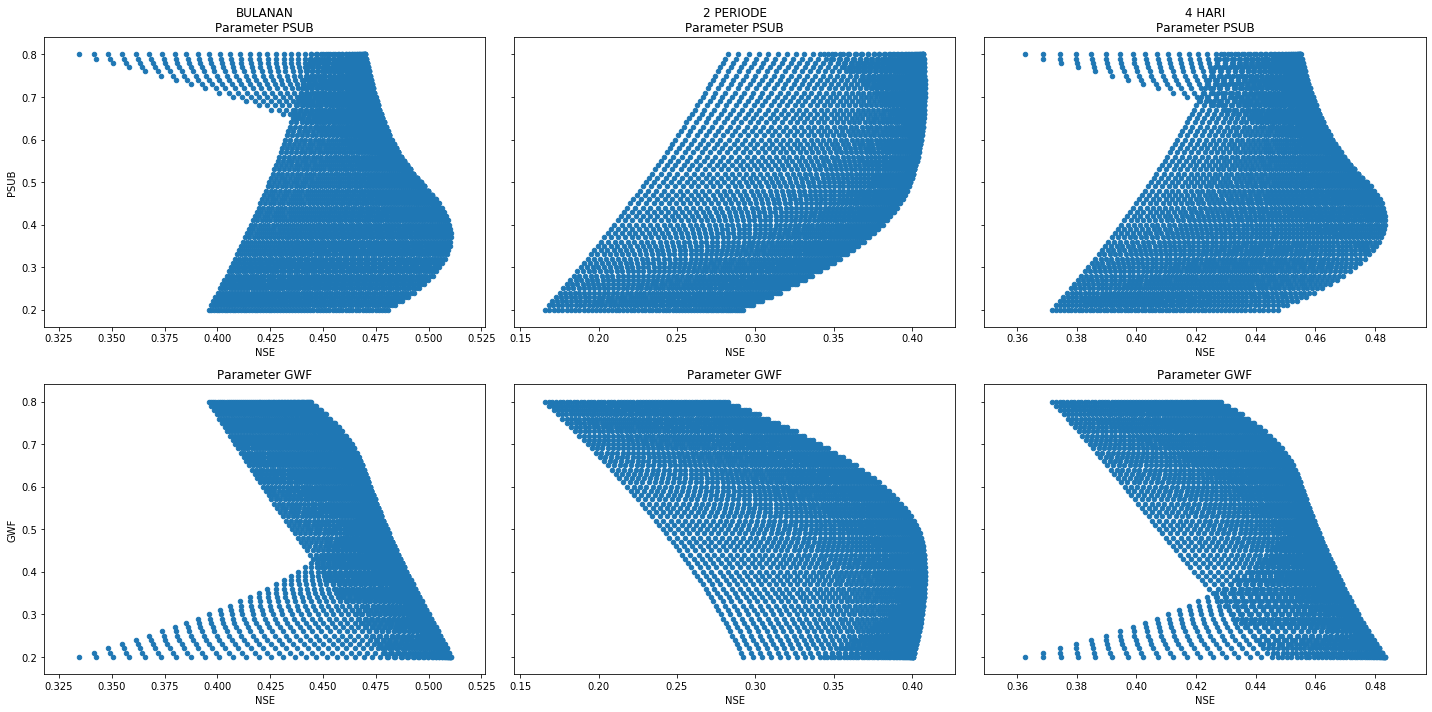

In [ ]:
plot_calib_res('NSE')

:: GRAFIK PARAMETER PSUB DAN GWF TERHADAP NILAI RMSE


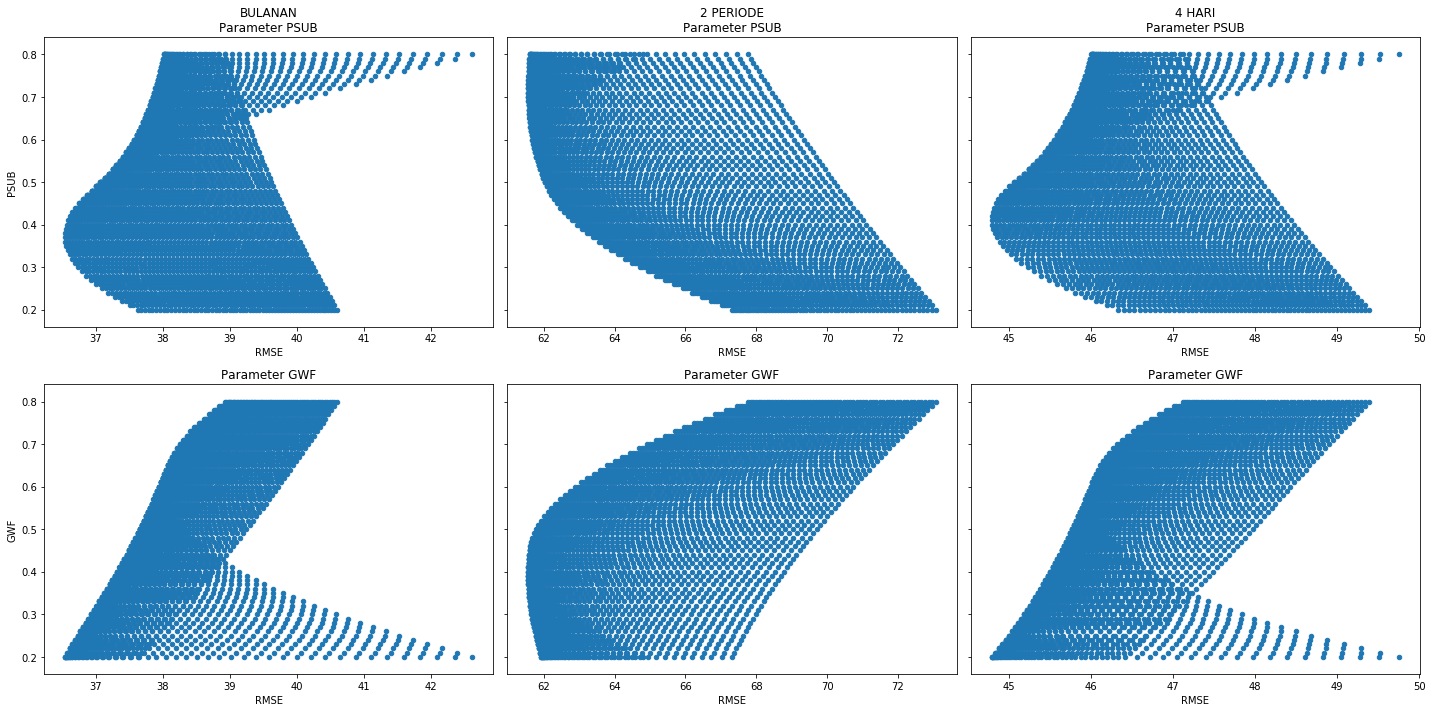

In [ ]:
plot_calib_res('RMSE')

:: GRAFIK PARAMETER PSUB DAN GWF TERHADAP NILAI R2


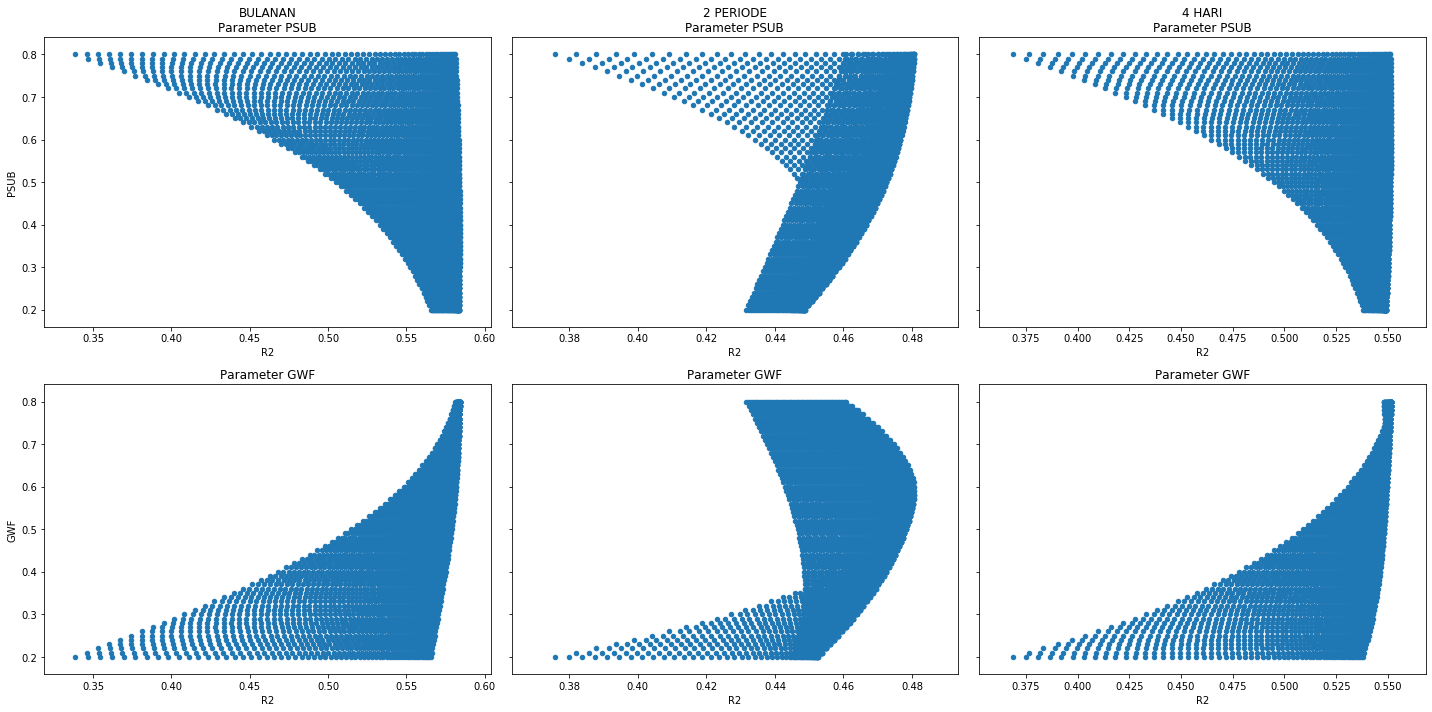

In [ ]:
plot_calib_res('R2')

:: GRAFIK PARAMETER PSUB DAN GWF TERHADAP NILAI NSE0608


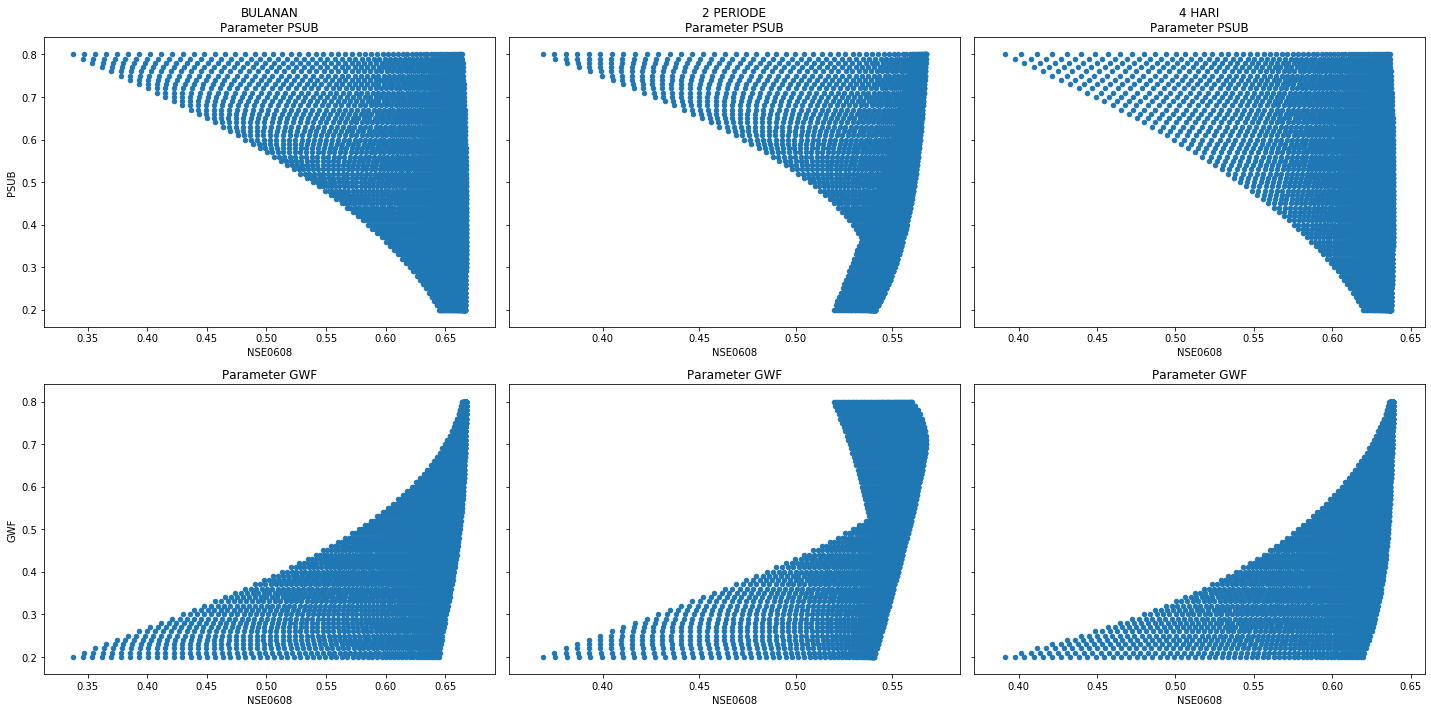

In [ ]:
plot_calib_res('NSE0608')

## Parameter Terbaik NRECA

In [ ]:
nreca_bulanan_best = hk90._best_parameter(results_bulanan, calib_nreca_params)
nreca_2p_best = hk90._best_parameter(results_2p, calib_nreca_params)
nreca_4d_best = hk90._best_parameter(results_4d, calib_nreca_params)
func_nreca_params['as_df'] = True

### Bulanan

:: PARAMETER TERBAIK BULANAN
{'MSTOR': 1000.0, 'GSTOR': 100.0, 'PSUB': 0.37000000000000016, 'GWF': 0.2}
:: GRAFIK DENGAN PARAMETER TERBAIK BULANAN


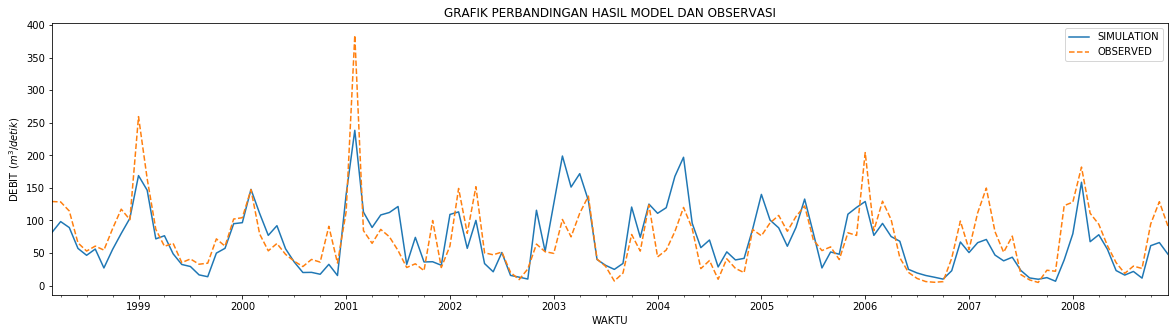

In [ ]:
print(':: PARAMETER TERBAIK BULANAN')
print(f'{nreca_bulanan_best}')

func_nreca_params['df'] = input_bulanan
print(':: GRAFIK DENGAN PARAMETER TERBAIK BULANAN')
nreca_plot(model_NRECA_custom(**func_nreca_params, **nreca_bulanan_best), 
           input_bulanan);

### 2 Periode

:: PARAMETER TERBAIK 2 PERIODE
{'MSTOR': 1000.0, 'GSTOR': 100.0, 'PSUB': 0.4100000000000002, 'GWF': 0.2}
:: GRAFIK DENGAN PARAMETER TERBAIK


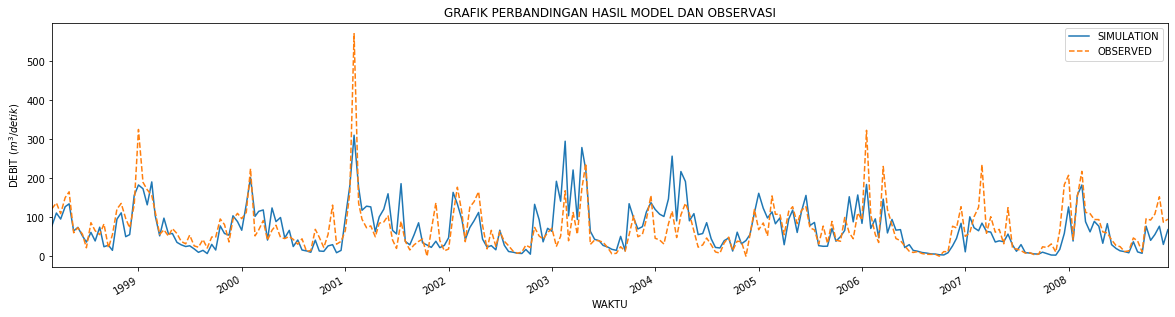

In [ ]:
print(':: PARAMETER TERBAIK 2 PERIODE')
print(f'{nreca_2p_best}')

func_nreca_params['df'] = input_2p
print(':: GRAFIK DENGAN PARAMETER TERBAIK')
nreca_plot(model_NRECA_custom(**func_nreca_params, **nreca_bulanan_best), 
           input_2p);

### 4 Hari

:: PARAMETER TERBAIK 4 HARI
{'MSTOR': 1000.0, 'GSTOR': 100.0, 'PSUB': 0.7200000000000004, 'GWF': 0.3900000000000002}
:: GRAFIK DENGAN PARAMETER TERBAIK


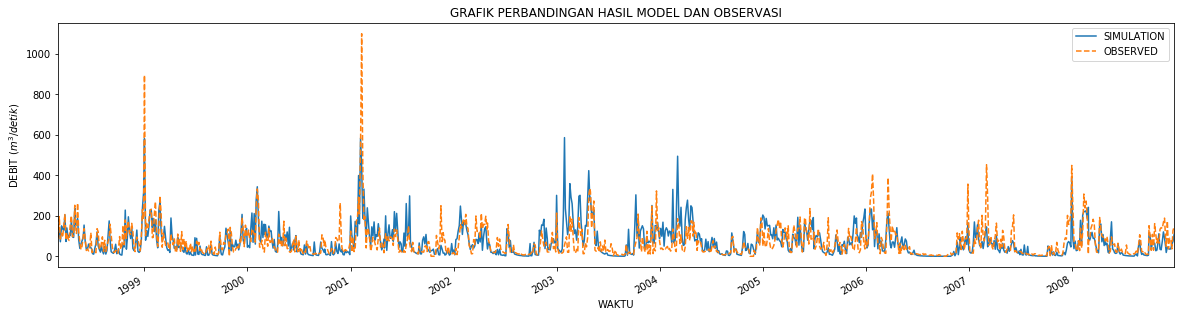

In [ ]:
print(':: PARAMETER TERBAIK 4 HARI')
print(f'{nreca_4d_best}')

func_nreca_params['df'] = input_4d
print(':: GRAFIK DENGAN PARAMETER TERBAIK')
nreca_plot(model_NRECA_custom(**func_nreca_params, **nreca_bulanan_best), 
           input_4d);

## Kalibrasi F.J. Mock

Kalibrasi model menggunakan modul `hidrokit.contrib.taruma.hk90` ([manual](https://gist.github.com/taruma/906e1577111208291e0725229c7d0a76)).

Pada model FJMOCK yang akan dicari parameter terbaiknya adalah `IF`, `K`, dan `PF` dengan batasan beserta _step_ $\{[0.5, 0.9) \in \mathbb{R}, 0.03\}$, $\{[0.1, 0.5) \in \mathbb{R}, 0.03\}$, $\{[0.01, 0.6) \in \mathbb{R}, 0.05\}$

In [ ]:
print(':: PARAMETER YANG DIKALIBRASI')
calib_fjmock_params = {
    'EXSURF': [30],
    'IF':  np.arange(0.5, 0.9, 0.03),
    'K': np.arange(0.1, 0.5, 0.03), 
    'PF': np.arange(0.01, 0.6, 0.05), 
    'ISMC': [300],
    'GSOM': [300],    
}
print(f'Kombinasi Parameter [calib_fjmock_params] = {calib_fjmock_params}')

:: PARAMETER YANG DIKALIBRASI
Kombinasi Parameter [calib_fjmock_params] = {'EXSURF': [30], 'IF': array([0.5 , 0.53, 0.56, 0.59, 0.62, 0.65, 0.68, 0.71, 0.74, 0.77, 0.8 ,
       0.83, 0.86, 0.89]), 'K': array([0.1 , 0.13, 0.16, 0.19, 0.22, 0.25, 0.28, 0.31, 0.34, 0.37, 0.4 ,
       0.43, 0.46, 0.49]), 'PF': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56]), 'ISMC': [300], 'GSOM': [300]}


In [ ]:
print(':: ARGUMEN FUNGSI FJMOCK')
func_fjmock_params = {
    'precip_col': 'precip',
    'ep_col': 'eto_mean',
    'nrain_col': 'nrain',
    'ndays_col': 'ndays',
    'AREA': 1450.6e6,

    'as_df': False,
}
print(f'{func_fjmock_params}')


:: ARGUMEN FUNGSI FJMOCK
{'precip_col': 'precip', 'ep_col': 'eto_mean', 'nrain_col': 'nrain', 'ndays_col': 'ndays', 'AREA': 1450600000.0, 'as_df': False}


### Bulanan

In [ ]:
func_fjmock_params['df'] = input_bulanan

print(':: KALIBRASI PARAMETER FJMOCK (BULANAN)')
results_bulanan = hk90.calibration(
    observed=input_bulanan, observed_func=obs_val,
    func=hk96.model_FJMOCK, calibration_parameter=calib_fjmock_params,
    func_parameter=func_fjmock_params,
    metrics=metrics_bulanan,
    **metrics_parameter
)

:: KALIBRASI PARAMETER FJMOCK (BULANAN)
N = 2352
PROGRESS 0 [-x--xx--x-] 100
---------> [==========] DONE


In [ ]:
print(':: MENAMPILKAN LIMA BARIS PERTAMA [results_bulanan]')
results_bulanan.head()

:: MENAMPILKAN LIMA BARIS PERTAMA [results_bulanan]


EXSURF      IF       K      PF  ISMC  GSOM     RMSE      R2     NSE  NSE0608
0      30 0.50000 0.19000 0.51000   300   300 42.56464 0.43788 0.33585  0.05643
1      30 0.50000 0.16000 0.51000   300   300 42.56860 0.43974 0.33572  0.05860
2      30 0.50000 0.22000 0.51000   300   300 42.57958 0.43557 0.33538  0.05383
3      30 0.50000 0.19000 0.46000   300   300 42.58760 0.45217 0.33513  0.05372
4      30 0.50000 0.13000 0.51000   300   300 42.59072 0.44118 0.33503  0.06038

### 2 Periode

In [ ]:
func_fjmock_params['df'] = input_2p

print(':: KALIBRASI PARAMETER FJMOCK (2 PERIODE)')
results_2p = hk90.calibration(
    observed=input_2p, observed_func=obs_val,
    func=hk96.model_FJMOCK, calibration_parameter=calib_fjmock_params,
    func_parameter=func_fjmock_params,
    metrics=metrics_2p,
    **metrics_parameter
)

:: KALIBRASI PARAMETER FJMOCK (2 PERIODE)
N = 2352
PROGRESS 0 [-x--xx--x-] 100
---------> [==========] DONE


In [ ]:
print(':: MENAMPILKAN LIMA BARIS PERTAMA [results_2p]')
results_2p.head()

:: MENAMPILKAN LIMA BARIS PERTAMA [results_2p]


EXSURF      IF       K      PF  ISMC  GSOM     RMSE      R2     NSE  NSE0608
0      30 0.50000 0.49000 0.11000   300   300 47.07007 0.50765 0.42953  0.50966
1      30 0.53000 0.49000 0.11000   300   300 47.19349 0.50176 0.42653  0.50343
2      30 0.50000 0.49000 0.16000   300   300 47.20777 0.50414 0.42619  0.55280
3      30 0.50000 0.46000 0.11000   300   300 47.21262 0.50891 0.42607  0.51147
4      30 0.53000 0.46000 0.11000   300   300 47.32573 0.50331 0.42332  0.50549

### 4 Hari

In [ ]:
func_fjmock_params['df'] = input_4d

print(':: KALIBRASI PARAMETER FJMOCK (4 HARI)')
results_4d = hk90.calibration(
    observed=input_4d, observed_func=obs_val,
    func=hk96.model_FJMOCK, calibration_parameter=calib_fjmock_params,
    func_parameter=func_fjmock_params,
    metrics=metrics_4d,
    **metrics_parameter
)

:: KALIBRASI PARAMETER FJMOCK (4 HARI)
N = 2352
PROGRESS 0 [-x--xx--x-] 100
---------> [==========] DONE


In [ ]:
print(':: MENAMPILKAN LIMA BARIS PERTAMA [results_4d]')
results_4d.head()

:: MENAMPILKAN LIMA BARIS PERTAMA [results_4d]


EXSURF      IF       K      PF  ISMC  GSOM     RMSE      R2     NSE  NSE0608
0      30 0.62000 0.49000 0.01000   300   300 66.88210 0.44594 0.30122  0.47806
1      30 0.65000 0.49000 0.01000   300   300 66.90186 0.44258 0.30081  0.46638
2      30 0.59000 0.49000 0.01000   300   300 66.94662 0.44859 0.29987  0.48835
3      30 0.68000 0.49000 0.01000   300   300 67.00583 0.43851 0.29863  0.45332
4      30 0.56000 0.49000 0.01000   300   300 67.09518 0.45056 0.29676  0.49726

### Perbandingan Kalibrasi FJMOCK setiap periode

In [ ]:
def plot_calib_res(_x):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10), 
                        sharex=False, sharey=False)
    ax0, ax1, ax2 = ax

    print(':: GRAFIK PARAMETER IF, K, PF TERHADAP NILAI ' + _x)
    results_bulanan.plot.scatter(x=_x, y='IF', title='BULANAN\nParameter IF', 
                                ax=ax0[0])
    results_4d.plot.scatter(x=_x, y='IF', title='2 PERIODE\nParameter IF', 
                            ax=ax0[1])
    results_2p.plot.scatter(x=_x, y='IF', title='4 HARI\nParameter IF', 
                            ax=ax0[2])

    results_bulanan.plot.scatter(x=_x, y='K', title='Parameter K', ax=ax1[0])
    results_4d.plot.scatter(x=_x, y='K', title='Parameter K', ax=ax1[1])
    results_2p.plot.scatter(x=_x, y='K', title='Parameter K', ax=ax1[2])
    
    results_bulanan.plot.scatter(x=_x, y='PF', title='Parameter PF', ax=ax2[0])
    results_4d.plot.scatter(x=_x, y='PF', title='Parameter PF', ax=ax2[1])
    results_2p.plot.scatter(x=_x, y='PF', title='Parameter PF', ax=ax2[2])
    
    plt.tight_layout()

:: GRAFIK PARAMETER IF, K, PF TERHADAP NILAI NSE


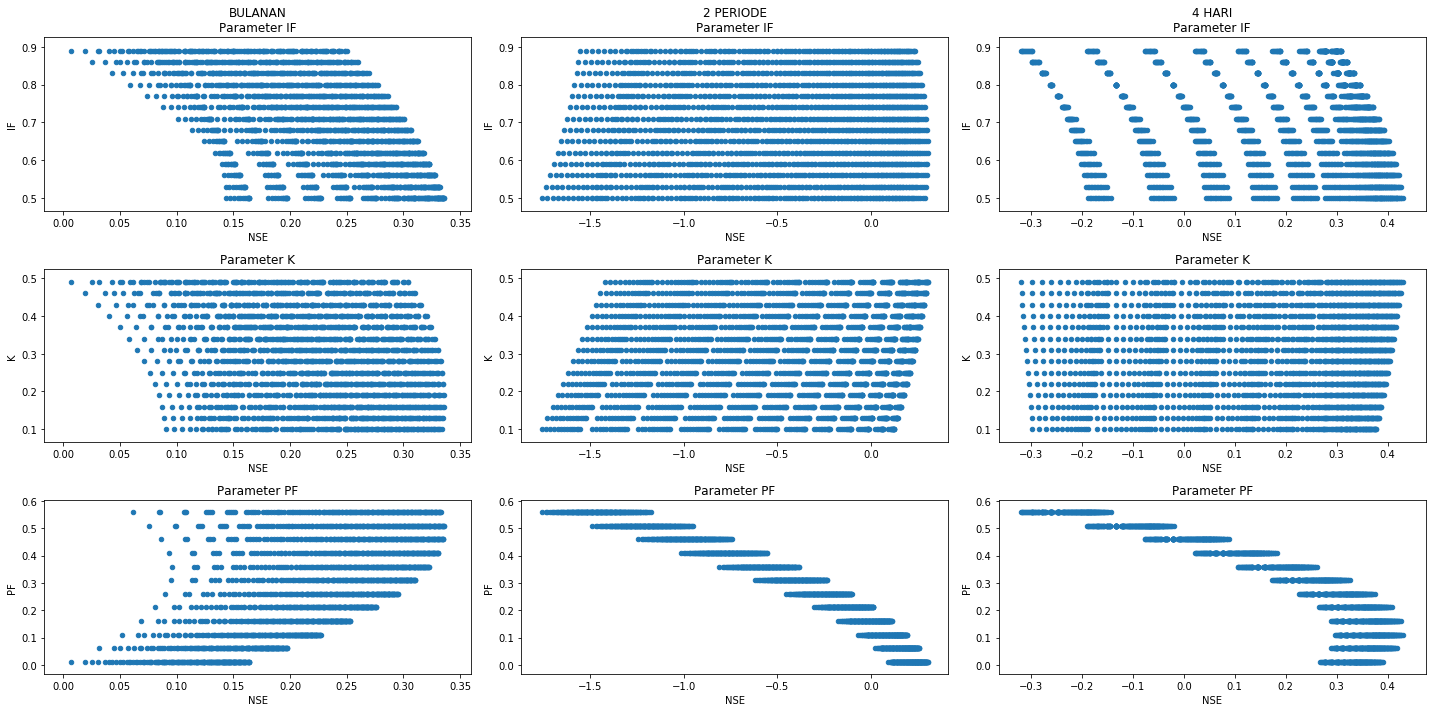

In [ ]:
plot_calib_res('NSE')

:: GRAFIK PARAMETER IF, K, PF TERHADAP NILAI RMSE


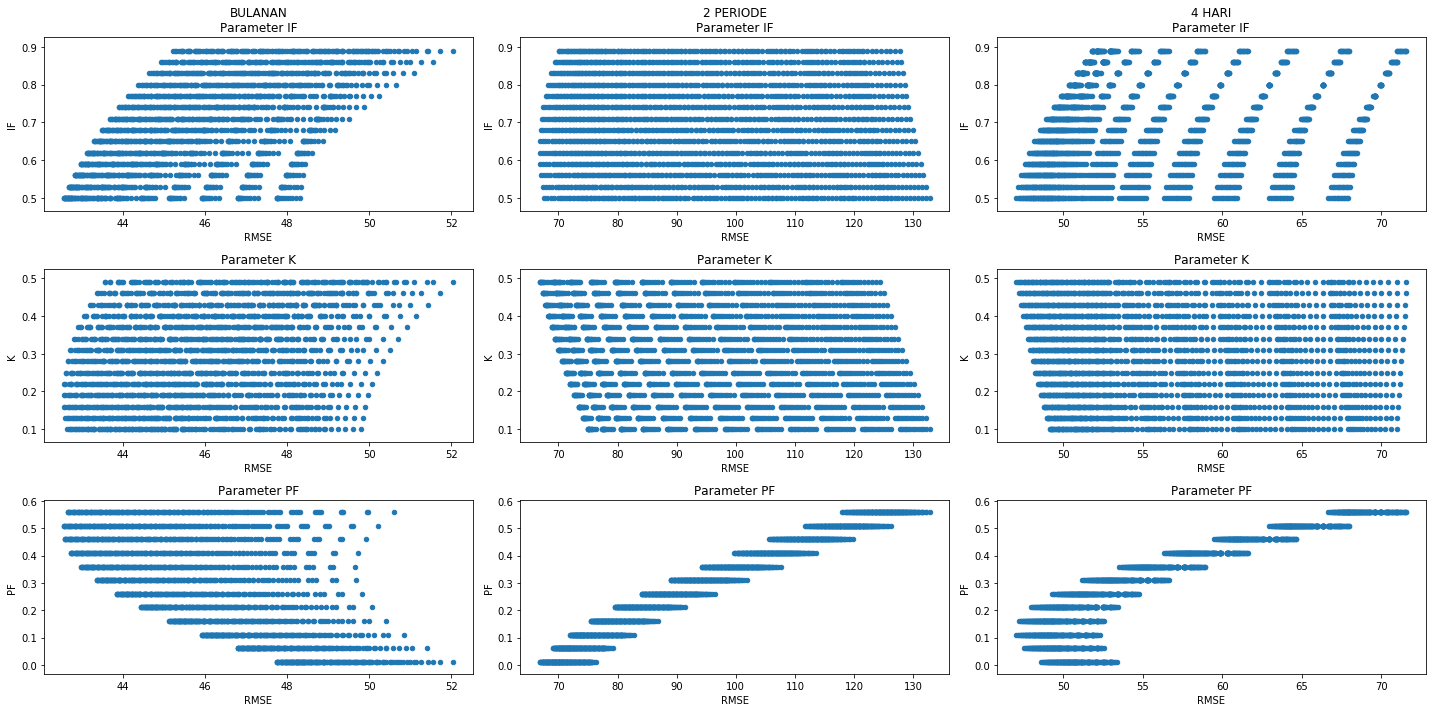

In [ ]:
plot_calib_res('RMSE')

:: GRAFIK PARAMETER IF, K, PF TERHADAP NILAI R2


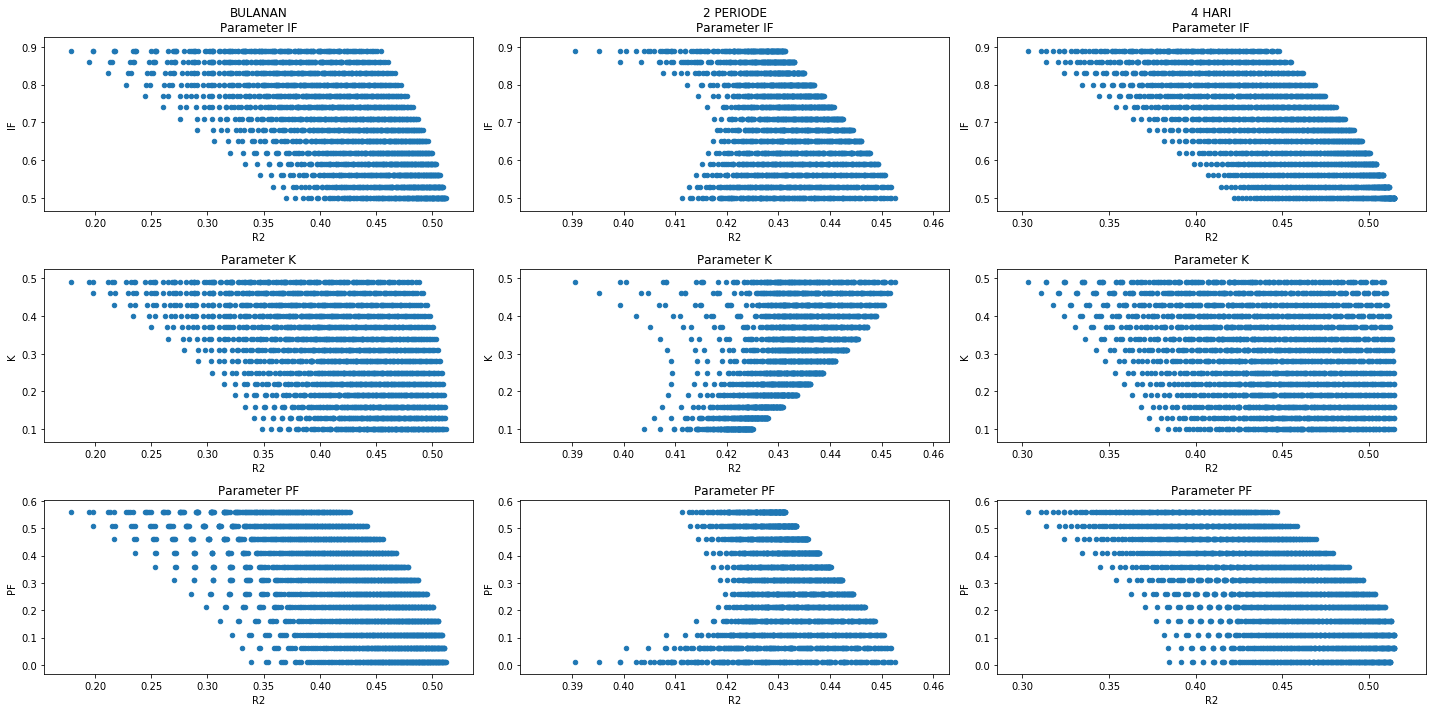

In [ ]:
plot_calib_res('R2')

:: GRAFIK PARAMETER IF, K, PF TERHADAP NILAI NSE0608


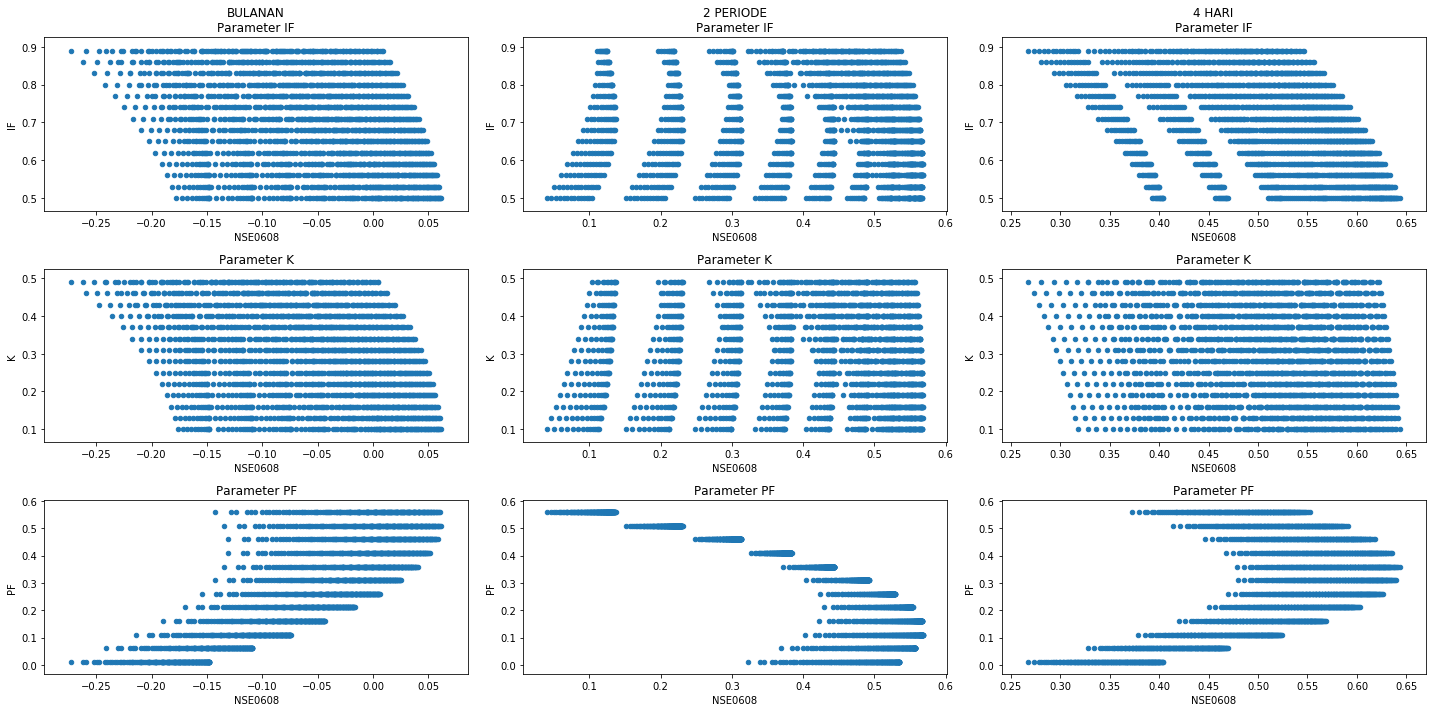

In [ ]:
plot_calib_res('NSE0608')

## Parameter Terbaik FJMOCK

In [ ]:
fjmock_bulanan_best = hk90._best_parameter(results_bulanan, calib_fjmock_params)
fjmock_2p_best = hk90._best_parameter(results_2p, calib_fjmock_params)
fjmock_4d_best = hk90._best_parameter(results_4d, calib_fjmock_params)
func_fjmock_params['as_df'] = True

### Bulanan

:: PARAMETER TERBAIK BULANAN
{'EXSURF': 30.0, 'IF': 0.5, 'K': 0.19, 'PF': 0.51, 'ISMC': 300.0, 'GSOM': 300.0}
:: GRAFIK DENGAN PARAMETER TERBAIK BULANAN


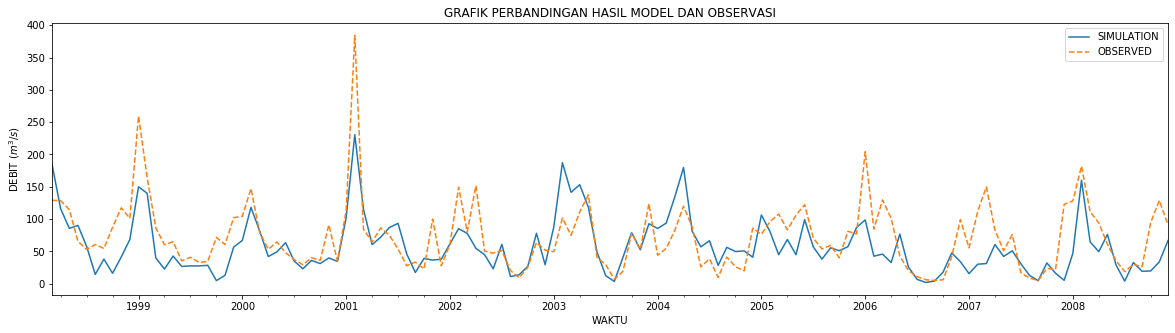

In [ ]:
print(':: PARAMETER TERBAIK BULANAN')
print(f'{fjmock_bulanan_best}')

func_fjmock_params['df'] = input_bulanan
print(':: GRAFIK DENGAN PARAMETER TERBAIK BULANAN')
fjmock_plot(hk96.model_FJMOCK(**func_fjmock_params, **fjmock_bulanan_best), 
           input_bulanan);

### 2 Periode

:: PARAMETER TERBAIK 2 PERIODE
{'EXSURF': 30.0, 'IF': 0.5, 'K': 0.49, 'PF': 0.11, 'ISMC': 300.0, 'GSOM': 300.0}
:: GRAFIK DENGAN PARAMETER TERBAIK 2p


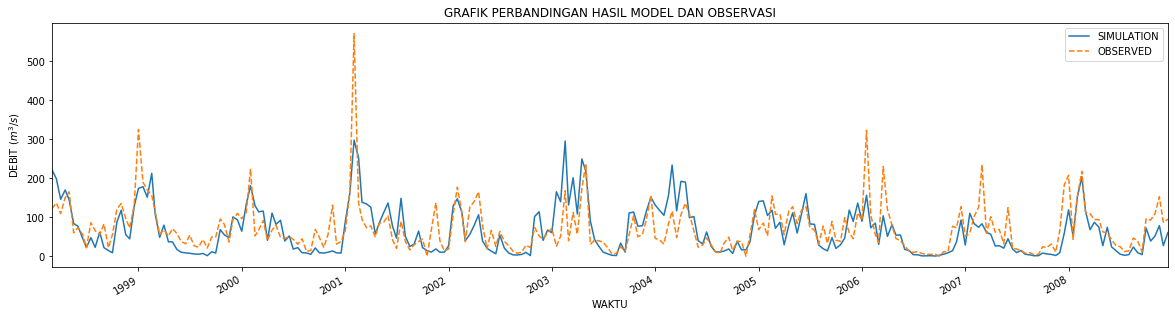

In [ ]:
print(':: PARAMETER TERBAIK 2 PERIODE')
print(f'{fjmock_2p_best}')

func_fjmock_params['df'] = input_2p
print(':: GRAFIK DENGAN PARAMETER TERBAIK 2p')
fjmock_plot(hk96.model_FJMOCK(**func_fjmock_params, **fjmock_2p_best), 
           input_2p);

### 4 Hari

:: PARAMETER TERBAIK 4 HARI
{'EXSURF': 30.0, 'IF': 0.6200000000000001, 'K': 0.49, 'PF': 0.01, 'ISMC': 300.0, 'GSOM': 300.0}
:: GRAFIK DENGAN PARAMETER TERBAIK 4d


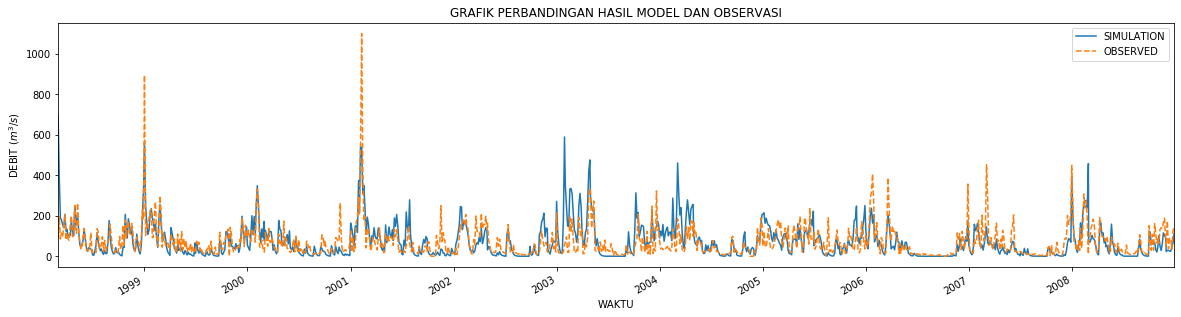

In [ ]:
print(':: PARAMETER TERBAIK 4 HARI')
print(f'{fjmock_4d_best}')

func_fjmock_params['df'] = input_4d
print(':: GRAFIK DENGAN PARAMETER TERBAIK 4d')
fjmock_plot(hk96.model_FJMOCK(**func_fjmock_params, **fjmock_4d_best), 
           input_4d);

## Perbandingan NRECA dan FJMOCK

In [ ]:
def nse_diff(nreca, fjmock, input_df):
    print(':: PERBANDINGAN NILAI NSE')
    obs = obs_val(input_df)
    print(f'NRECA = {he.nse(nreca.iloc[:, 0], obs)}')
    print(f'FJMOCK = {he.nse(fjmock.iloc[:, 0], obs)}')

def plot_diff(nreca, fjmock, input_df):
    print(':: GRAFIK PERBANDINGAN')
    ax = nreca['DISCHARGE'].plot(figsize=(20, 5))
    fjmock['FLOW'].plot(ax=ax, style='r--')
    input_df['debit'].plot(ax=ax, style='y:')
    ax.legend(['NRECA', 'FJMOCK', 'OBSERVED'])
    ax.set_xlabel('WAKTU')
    ax.set_ylabel('DEBIT $(m^3/detik)$')
    ax.set_title('GRAFIK PERBANDINGAN HASIL SIMULASI DAN OBSERVASI')

### Bulanan

:: PERBANDINGAN NILAI NSE
NRECA = 0.510475590648618
FJMOCK = 0.33584634163377713
:: GRAFIK PERBANDINGAN


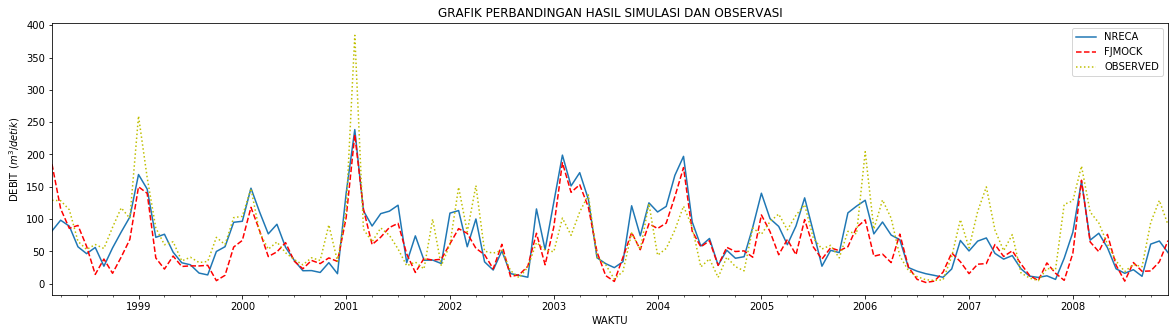

In [ ]:
func_nreca_params['df'] = input_bulanan
nreca_bulanan = model_NRECA_custom(**func_nreca_params, **nreca_bulanan_best)

func_fjmock_params['df'] = input_bulanan
fjmock_bulanan = hk96.model_FJMOCK(**func_fjmock_params, **fjmock_bulanan_best)

nse_diff(nreca_bulanan, fjmock_bulanan, input_bulanan)
plot_diff(nreca_bulanan, fjmock_bulanan, input_bulanan)

### 2 Periode

:: PERBANDINGAN NILAI NSE
NRECA = 0.48343371186614803
FJMOCK = 0.42952998182759805
:: GRAFIK PERBANDINGAN


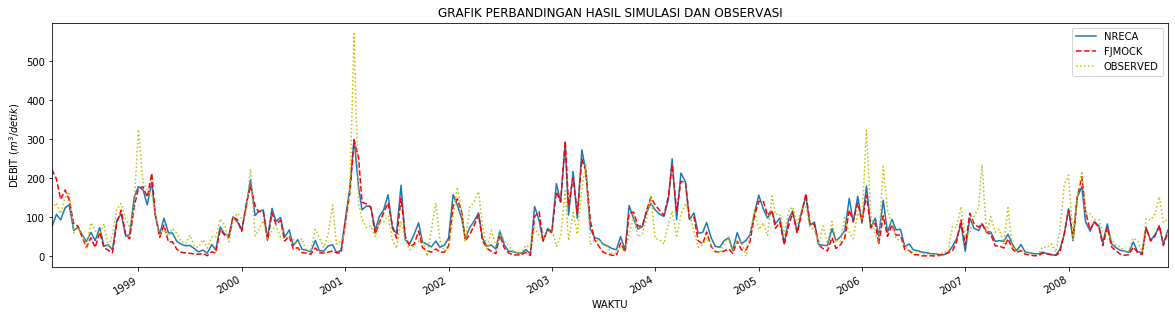

In [ ]:
func_nreca_params['df'] = input_2p
nreca_2p = model_NRECA_custom(**func_nreca_params, **nreca_2p_best)

func_fjmock_params['df'] = input_2p
fjmock_2p = hk96.model_FJMOCK(**func_fjmock_params, **fjmock_2p_best)

nse_diff(nreca_2p, fjmock_2p, input_2p)
plot_diff(nreca_2p, fjmock_2p, input_2p)

### 4 Hari

:: PERBANDINGAN NILAI NSE
NRECA = 0.4079933316452993
FJMOCK = 0.3012180465312787
:: GRAFIK PERBANDINGAN


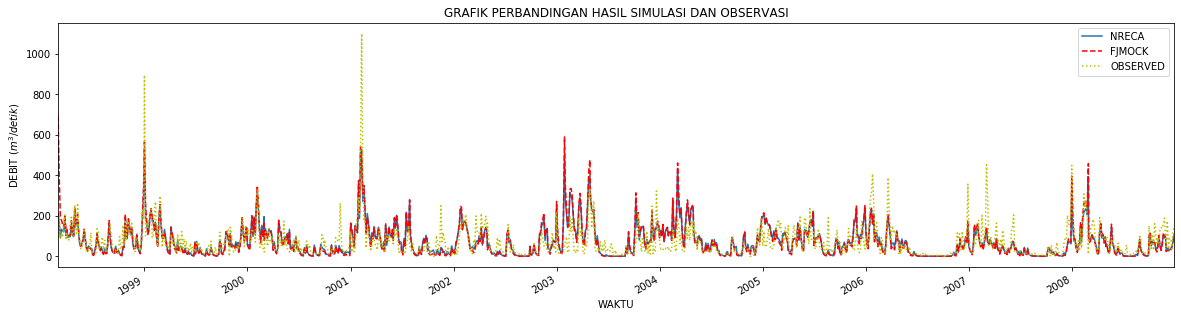

In [ ]:
func_nreca_params['df'] = input_4d
nreca_4d = model_NRECA_custom(**func_nreca_params, **nreca_4d_best)

func_fjmock_params['df'] = input_4d
fjmock_4d = hk96.model_FJMOCK(**func_fjmock_params, **fjmock_4d_best)

nse_diff(nreca_4d, fjmock_4d, input_4d)
plot_diff(nreca_4d, fjmock_4d, input_4d)

### Debit Andal (Kurva Durasi)

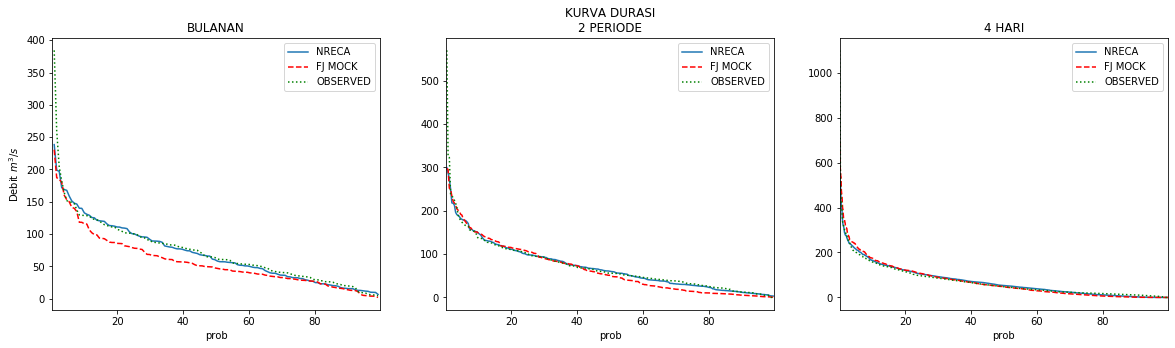

In [ ]:
plot_kurva_debit([input_bulanan, input_2p, input_4d],
                 [nreca_bulanan, nreca_2p, nreca_4d],
                 [fjmock_bulanan, fjmock_2p, fjmock_4d])

In [ ]:
print(':: NILAI DEBIT ANDAL')
debit_andal([input_bulanan, input_2p, input_4d],
            [nreca_bulanan, nreca_2p, nreca_4d],
            [fjmock_bulanan, fjmock_2p, fjmock_4d])

:: NILAI DEBIT ANDAL
:: DEBIT ANDAL BULANAN
NRECA: {80: 25.27775606990272, 90: 15.57189346891495, 95: 11.902671940081682}
FJMOCK: {80: 26.642111533243124, 90: 13.744880492498613, 95: 4.941980193453894}
OBSERVED: {80: 29.44870967741936, 90: 19.844599999999996, 95: 8.880540322580645}
:: DEBIT ANDAL 2 PERIODE
NRECA: {80: 23.41310223037494, 90: 11.965927319431563, 95: 8.498458218025636}
FJMOCK: {80: 10.39243508345192, 90: 5.324493687223216, 95: 2.572249940988722}
OBSERVED: {80: 25.21499047619047, 90: 12.777500000000005, 95: 7.975470833333335}
:: DEBIT ANDAL 4 HARI
NRECA: {80: 11.375311429172092, 90: 3.0067207533605407, 95: 0.17525378472814995}
FJMOCK: {80: 6.368452310275181, 90: 0.9359099900638773, 95: 0.15804365139389917}
OBSERVED: {80: 17.352, 90: 10.868, 95: 6.511999999999998}


# Changelog

```
- 20200116 - 1.0.0 - Initial
```

#### Copyright &copy; 2020 [Taruma Sakti Megariansyah](https://taruma.github.io)

Source code in this notebook is licensed under a [MIT License](https://choosealicense.com/licenses/mit/). Data in this notebook is licensed under a [Creative Common Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/). 
